In [ ]:
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset
import os
import glob
from torch.utils.data import DataLoader
import cv2
import albumentations as A
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from torchvision import models
import torch.optim as optim
import torch.nn.functional as F
from collections import defaultdict
import pandas as pd
from PIL import Image
import torch.nn as nn
from torch.utils.data import WeightedRandomSampler
import torchvision.utils as vutils
from torch.utils.data import ConcatDataset
import torch
from google.colab import drive


/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.6' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [ ]:
# pip install --upgrade torch torchvision

In [ ]:
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
!unzip -q /content/drive/MyDrive/dl-2025-competition-1.zip

In [ ]:
print("–§–∞–π–ª –Ω–∞–π–¥–µ–Ω?", os.path.exists("/content/drive/MyDrive/dl-2025-competition-1.zip"))

–§–∞–π–ª –Ω–∞–π–¥–µ–Ω? True


In [ ]:
# !ls "/content/drive/MyDrive"

In [ ]:
!ls data

test  train


In [ ]:
!ls sample_submission.csv

sample_submission.csv


## **–ö—É—â–µ–Ω–∫–æ –í–∞–ª–µ—Ä–∏—è - id 25**

–¥–ª—è —É–¥–æ–±–Ω–æ–≥–æ –ø–µ—Ä–µ–º–µ—â–µ–Ω–∏—è –ø–æ –Ω–æ—É—Ç–±—É–∫—É –ø–µ—Ä–µ–¥–≤–∏–≥–∞–π—Ç–µ—Å—å –ø–æ –∑–∞–≥–æ–ª–æ–≤–∫–∞–º –≤ –º–µ–Ω—é - p.s. gan –≤—ã–ø–æ–ª–Ω–µ–Ω –≤ —Å–∞–º–æ–º –∫–æ–Ω—Ü–µ

## –Ω–∞—á–∞–ª–æ —Ä–∞–±–æ—Ç—ã

–∏–∑ –≤–∞–∂–Ω–æ–≥–æ: —Å–æ—Ä—Ç–∏—Ä—É–µ–º —Ñ–∞–π–ª—ã –≤ —Ç–µ—Å—Ç–æ–≤–æ–º –¥–∞—Ç–∞—Å–µ—Ç–µ, –¥–æ–±–∞–≤–ª—è–µ–º —É—Å–ª–æ–≤–Ω—É—é –∞—É–≥–º–µ–Ω—Ç–∞—Ü–∏—é, —á–∏—Ç–∞–µ–º –∫–∞—Ä—Ç–∏–Ω–∫–∏

In [ ]:
class ImageFolderDataset(Dataset):
    def __init__(self, split="train", root_dir="data/train", transform=None, rare_class_transform=None):
        self.split = split
        self.transform = transform
        self.rare_class_transform = rare_class_transform
        self.samples = []

        if split == "test":
            root_dir = "data/test"
            image_files = glob.glob(os.path.join(root_dir, "*.jpg")) + glob.glob(os.path.join(root_dir, "*.png"))
            # —Ç–∞–∫–∂–µ –æ—Ç—Å–æ—Ä—Ç–∏—Ä—É–µ–º
            def extract_number(path):
                imya = os.path.splitext(os.path.basename(path))[0]
                return int(imya) if imya.isdigit() else float("inf")

            image_files = sorted(image_files, key=extract_number)

            for file_path in image_files:
                self.samples.append((file_path, 0))
        else:

            def split_files(files, split):
                n = len(files)
                if split == "train":
                    return files[: int(0.8 * n)]
                elif split == "val":
                    return files[int(0.8 * n) :]
                elif split == "train_itog":
                    return files

            for class_folder in sorted(os.listdir(root_dir)):
                class_path = os.path.join(root_dir, class_folder)
                if os.path.isdir(class_path):
                    class_idx = int(class_folder)
                    image_files = glob.glob(os.path.join(class_path, "*"))
                    split_files_list = split_files(image_files, split)
                    for file_path in split_files_list:
                        self.samples.append((file_path, class_idx))
        # –Ω–∞–π–¥–µ–º —Ä–µ–¥–∫–∏–µ –∫–ª–∞—Å—Å—ã (–ø–æ—Ç–æ–º –∏—Ö –æ—Ç–ø—Ä–∞–≤–∏–º –≤ —É—Å–ª–æ–≤–Ω—É—é –∞—É–≥–º–µ–Ω—Ç–∞—Ü–∏—é)
        label_counts = Counter([label for x, label in self.samples])
        self.rare_classes = {label for label, count in label_counts.items() if count < 40}

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = cv2.imread(img_path)
        img_pil = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        image = np.array(img_pil.resize((64, 64), Image.BILINEAR) )

        if self.transform:
          # —É—Å–ª–æ–≤–Ω–∞—è –∞–≥—É–º–µ–Ω—Ç–∞—Ü–∏—è
            if label in self.rare_classes and self.rare_class_transform:
                augmented = self.rare_class_transform(image=image)
            else:
                augmented = self.transform(image=image)
            image = augmented["image"]

        return image, label

## –∞—É–≥–º–µ–Ω—Ç–∞—Ü–∏–∏, –¥–∞—Ç–∞–ª–æ—É–¥–µ—Ä—ã, –¥–∞—Ç–∞—Å–µ—Ç—ã...

–∞—É–≥–º–µ–Ω—Ç–∞—Ü–∏–∏ –±–µ—Å—Å—Ç—ã–∂–∏–º –æ–±—Ä–∞–∑–æ–º –±—ã–ª–∏ –ø–æ–¥—Å–º–æ—Ç—Ä–µ–Ω—ã –≤ —Å–µ–º–∏–Ω–∞—Ä—Å–∫–æ–º –Ω–æ—É—Ç–±—É–∫–µ

In [ ]:
train_transform = A.Compose(
    [
        A.Resize(224, 224, interpolation=cv2.INTER_CUBIC),
        A.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0), ratio=(0.9, 1.1), p=1.0),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.1),
        # A.RandomRotate90(p=0.1),
        A.PixelDropout(p=0.5),
        A.Sharpen(alpha=(0.1, 0.7)),
        A.Normalize(),
        ToTensorV2(),
    ]
)

In [ ]:
train_transform_navorochenny = A.Compose(
    [
        A.Resize(224, 224, p=1.0, interpolation=cv2.INTER_CUBIC),
        A.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0), ratio=(0.9, 1.1), p=1.0),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.1),
        A.RandomRotate90(p=0.5),
        A.PixelDropout(p=0.5),
        A.Sharpen(alpha=(0.1, 0.7)),
        A.OneOf(
            [
                A.RandomBrightnessContrast(p=0.5),
                A.HueSaturationValue(p=0.5),
                A.GaussianBlur(p=0.3),
                A.RandomGamma(p=0.3),
            ],
            p=0.5,
        ),
        A.RandomOrder(
            [
                A.OpticalDistortion(p=0.3),
                A.GridDistortion(p=0.3),
                A.ElasticTransform(p=0.3),
            ]
        ),
        A.Normalize(),
        ToTensorV2(),
    ]
)

In [ ]:
rare_class_transform = A.Compose(
    [
        A.Resize(224, 224, interpolation=cv2.INTER_CUBIC),
        A.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0), ratio=(0.9, 1.1), p=1.0),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.1),
        A.RandomRotate90(p=0.5),
        A.PixelDropout(p=0.5),
        A.Sharpen(alpha=(0.1, 0.7)),
        A.OneOf(
            [
                A.RandomBrightnessContrast(p=0.5),
                A.HueSaturationValue(p=0.5),
                A.GaussianBlur(p=0.3),
                A.RandomGamma(p=0.3),
            ],
            p=0.5,
        ),
        A.Normalize(),
        ToTensorV2(),
    ]
)

In [ ]:
val_transform = A.Compose([
    A.Resize(224, 224, interpolation=cv2.INTER_CUBIC),
    A.Normalize(),
    ToTensorV2()
])

In [ ]:
train_dataset = ImageFolderDataset(root_dir="./data/train", split="train", transform=train_transform, rare_class_transform=rare_class_transform )
val_dataset = ImageFolderDataset(root_dir="./data/train", split="val", transform=val_transform)
test_dataset = ImageFolderDataset(root_dir="./data/test", split="test", transform=val_transform)

In [ ]:
# –ø–æ—Å—Ç—Ä–æ–∏–º —Å–µ–º–ø–ª–µ—Ä –∫–æ—Ç–æ—Ä—ã–π –±–µ—Ä–µ—Ç –±–æ–ª–µ–µ —Ä–µ–¥–∫–∏–µ –∫–ª–∞—Å—Å—ã –≤ –±–∞—Ç—á–∏ —á–∞—â–µ
labels = [label for x, label in train_dataset.samples]
sample_weights = (1.0 / torch.tensor(np.bincount(labels), dtype=torch.float))[labels]
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=64, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

## –ü–æ—Å–º–æ—Ç—Ä–∏–º –Ω–∞ –¥–∞–Ω–Ω—ã–µ –∏ –ø—Ä–æ–∞–Ω–∞–ª–∏–∑–∏—Ä—É–µ–º –∏—Ö

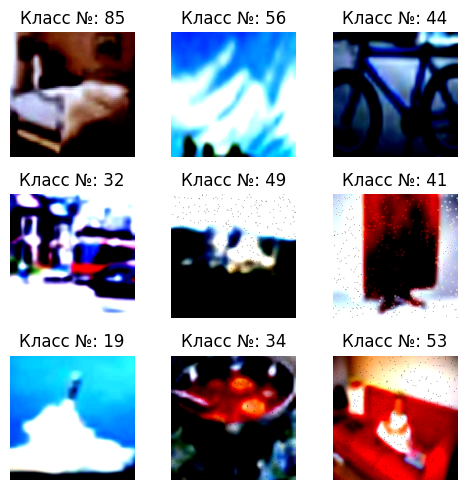

In [ ]:
def imshow(img_tensor, title, plt_ax):
    img = img_tensor.permute(1, 2, 0).numpy()
    plt_ax.imshow(img)
    plt_ax.set_title(title)
    plt_ax.axis("off")

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(5, 5), sharey=True, sharex=True)
for x in ax.flatten():
    im_train, label = train_dataset[int(np.random.uniform(0, len(train_dataset)))]
    imshow(im_train.cpu(), title=f"–ö–ª–∞—Å—Å ‚Ññ: {label}", plt_ax=x)
plt.tight_layout()
plt.show()

In [ ]:
labels = [label for x, label in train_dataset]
num_classes = len(set(labels))
print(f"–ë—É–¥–µ–º –∫–ª–∞—Å—Å–∏—Ñ–∏—Ü–∏—Ä–æ–≤–∞—Ç—å –º–Ω–æ–≥–æ –∫–ª–∞—Å—Å–æ–≤: {num_classes}")

–ë—É–¥–µ–º –∫–ª–∞—Å—Å–∏—Ñ–∏—Ü–∏—Ä–æ–≤–∞—Ç—å –º–Ω–æ–≥–æ –∫–ª–∞—Å—Å–æ–≤: 100


In [ ]:
labels = [label for x, label in train_dataset.samples]
amount_of_classes= Counter(labels)
for cls, count in sorted(amount_of_classes.items())[:10]:
    print(f"–ö–ª–∞—Å—Å {cls}: {count} –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–π")
print(f"\n–í—Å–µ–≥–æ –∫–ª–∞—Å—Å–æ–≤: {len(amount_of_classes)}")

–ö–ª–∞—Å—Å 0: 88 –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–π
–ö–ª–∞—Å—Å 1: 87 –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–π
–ö–ª–∞—Å—Å 2: 114 –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–π
–ö–ª–∞—Å—Å 3: 95 –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–π
–ö–ª–∞—Å—Å 4: 108 –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–π
–ö–ª–∞—Å—Å 5: 36 –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–π
–ö–ª–∞—Å—Å 6: 98 –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–π
–ö–ª–∞—Å—Å 7: 109 –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–π
–ö–ª–∞—Å—Å 8: 36 –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–π
–ö–ª–∞—Å—Å 9: 39 –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–π

–í—Å–µ–≥–æ –∫–ª–∞—Å—Å–æ–≤: 100


–ü–æ—Å–º–æ—Ç—Ä–∏–º –Ω–∞ —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –∫–ª–∞—Å—Å–æ–≤

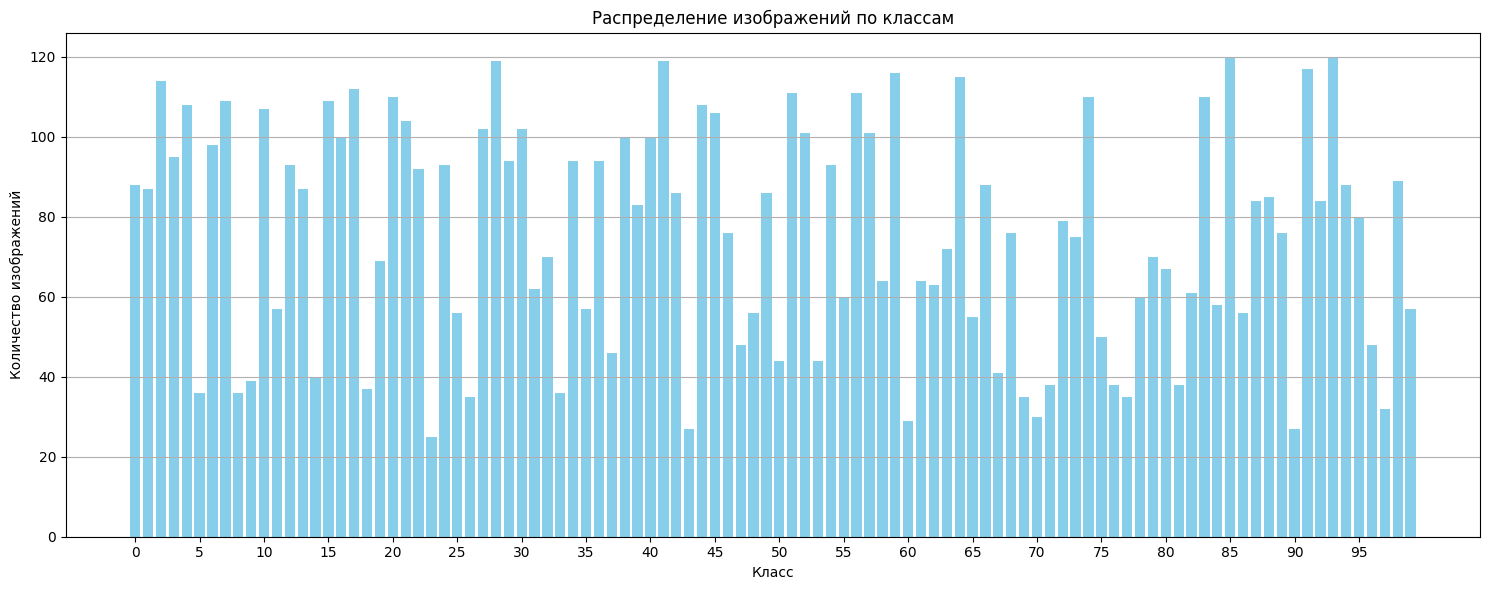

In [ ]:
classes = list(amount_of_classes.keys())
counts = list(amount_of_classes.values())
plt.figure(figsize=(15, 6))
plt.bar(classes, counts, color="skyblue")
plt.xlabel("–ö–ª–∞—Å—Å")
plt.ylabel("–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–π")
plt.title("–†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–π –ø–æ –∫–ª–∞—Å—Å–∞–º")
plt.xticks(ticks=range(0, max(classes) + 1, max(1, len(classes) // 20)))
plt.grid(axis="y")
plt.tight_layout()
plt.show()

–ó–∞–º–µ—Ç–µ–Ω –¥–∏—Å–±–∞–ª–∞–Ω—Å! –ø–æ—Å–º–æ—Ç—Ä–∏–º, –∫–∞–∫–∏–µ –∫–ª–∞—Å—Å—ã –ø—Ä–µ–¥—Å—Ç–∞–≤–ª–µ–Ω—ã —Ä–µ–∂–µ –≤—Å–µ–≥–æ, –±—É–¥–µ–º —Ä–µ—à–∞—Ç—å —ç—Ç—É –ø—Ä–æ–±–ª–µ–º—É —Å –ø–æ–º–æ—â—å—é —Å–µ–º–ø–ª–µ—Ä–∞ –∏ —É—Å–ª–æ–≤–Ω–æ–π –∞—É–≥–º–µ–Ω—Ç–∞—Ü–∏–∏ (–¥–æ–±–∞–≤–ª–µ–Ω–∞ –≤ —Ñ—É–Ω–∫—Ü–∏—é –¥–∞—Ç–∞—Å–µ—Ç–∞)

–í—ã–≤–µ–¥–µ–º —Å–∞–º—ã–µ —Ä–µ–¥–∫–∏–µ –∫–ª–∞—Å—Å—ã:

In [ ]:
rare_class = sorted(amount_of_classes.items(), key=lambda x: x[1])[:15]
for class_id, count in rare_class:
    print(f"–ö–ª–∞—Å—Å {class_id}: {count} –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–π")

–ö–ª–∞—Å—Å 23: 25 –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–π
–ö–ª–∞—Å—Å 43: 27 –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–π
–ö–ª–∞—Å—Å 90: 27 –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–π
–ö–ª–∞—Å—Å 60: 29 –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–π
–ö–ª–∞—Å—Å 70: 30 –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–π
–ö–ª–∞—Å—Å 97: 32 –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–π
–ö–ª–∞—Å—Å 26: 35 –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–π
–ö–ª–∞—Å—Å 69: 35 –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–π
–ö–ª–∞—Å—Å 77: 35 –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–π
–ö–ª–∞—Å—Å 33: 36 –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–π
–ö–ª–∞—Å—Å 5: 36 –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–π
–ö–ª–∞—Å—Å 8: 36 –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–π
–ö–ª–∞—Å—Å 18: 37 –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–π
–ö–ª–∞—Å—Å 71: 38 –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–π
–ö–ª–∞—Å—Å 76: 38 –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–π


–ü–æ—Å—Ç–∞–≤–ª—é –ø–æ—Ä–æ–≥ –¥–ª—è —É—Å–ª–æ–≤–Ω–æ–π –∞—É–≥–º–µ–Ω—Ç–∞—Ü–∏–∏ –Ω–∞ 40 –∫–∞—Ä—Ç–∏–Ω–æ–∫

In [ ]:
# –ø–æ—Å–º–æ—Ç—Ä–∏–º, –∫–∞–∫–æ–≥–æ —Ä–∞–∑–º–µ—Ä–∞ –∫–∞—Ä—Ç–∏–Ω–∫–∏
H, W, C = cv2.imread("./data/train/0/5926.png").shape
print(f"–†–∞–∑–º–µ—Ä –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏—è: {W}x{H}, –∫–∞–Ω–∞–ª–æ–≤: {C}")

–†–∞–∑–º–µ—Ä –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏—è: 32x32, –∫–∞–Ω–∞–ª–æ–≤: 3


In [ ]:
num_classes = 100

# –ù–µ–æ–±—Ö–æ–¥–∏–º—ã–µ —Ñ—É–Ω–∫—Ü–∏–∏

–ü–æ –∏—Ç–æ–≥–∞–º –≤—Å–µ–≥–æ –Ω–∏–∂–µ- –∏ –≤—ã—à–µ–ø–µ—Ä–µ—á–∏—Å–ª–µ–Ω–Ω–æ–≥–æ –≤ –∫–∞–∂–¥–æ–π –º–æ–¥–µ–ª—å–∫–µ –±—É–¥–µ—Ç (–µ—Å–ª–∏ —è —ç—Ç–æ –Ω–µ –±—É–¥—É —Å–ø–µ—Ü–∏–∞–ª—å–Ω–æ —É–±–∏—Ä–∞—Ç—å) (–∞ —è –Ω–µ —É–±–∏—Ä–∞–ª–∞):


*   –∞–ø—Å–∫–µ–π–ª–∏–Ω–≥ –¥–æ 224—Ö224
*   –∞—É–≥–º–µ–Ω—Ç–∞—Ü–∏–∏ (–Ω–∞–≤–æ—Ä–æ—á–µ–Ω–Ω—ã–µ –ø—Ä–æ–≤–µ—Ä—é –Ω–∞ –±–∞–∑–æ–≤–æ–π –º–æ–¥–µ–ª–∏)
*   —É—Å–ª–æ–≤–Ω–∞—è –∞—É–≥–º–µ–Ω—Ç–∞—Ü–∏—è –¥–ª—è –æ—á–µ–Ω—å –º–∞–ª–µ–Ω—å–∫–∏—Ö –∫–ª–∞—Å—Å–æ–≤ (—Ç–∞–º, –≥–¥–µ –∫–∞—Ä—Ç–∏–Ω–æ–∫ <40)
*   –≥—Ä–∞—Ñ–∏–∫ —Å –ª–æ—Å—è–º–∏ –∏ –º–µ—Ç—Ä–∏–∫–æ–π
*   —Å–æ—Ö—Ä–∞–Ω–µ–Ω–∏–µ –ª—É—á—à–µ–π –º–æ–¥–µ–ª–∏ –≤–æ –≤—Ä–µ–º—è –æ–±—É—á–µ–Ω–∏—è
*   —Ä–∞–Ω–Ω—è—è –æ—Å—Ç–∞–Ω–æ–≤–∫–∞ –≤–æ –≤—Ä–µ–º—è –æ–±—É—á–µ–Ω–∏—è
*   —Å—ç–º–ø–ª–µ—Ä –¥–ª—è –∏–∑–±–∞–≤–ª–µ–Ω–∏—è –æ—Ç –¥–∏—Å–±–∞–ª–∞–Ω—Å–∞

–ø–æ –≤–æ–∑–º–æ–∂–Ω–æ—Å—Ç–∏ —è —Å—Ç–∞—Ä–∞–ª–∞—Å—å –ø—Ä–∏–∫—Ä–µ–ø–ª—è—Ç—å —Å–∫—Ä–∏–Ω—ã —Å–æ —Å–∫–æ—Ä–æ–º –∏–∑ –∫–∞–≥–≥–ª–∞






In [ ]:
def train_model(model,train_loader,val_loader,criterion,optimizer,device,num_epochs=20,patience=5,save_path="best_model.pth"):
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    best_val_acc = 0.0
    best_model_state = None
    no_improve = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            running_loss += loss.item() * images.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        print(
            f"Epoch {epoch+1}/{num_epochs} | Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.4f}"
        )

        #–≤–∞–ª–∏–¥–∞—Ü–∏—è
        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
                val_running_loss += loss.item() * images.size(0)

        val_loss = val_running_loss / len(val_loader.dataset)
        val_acc = val_correct / val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch+1}/{num_epochs} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

        # —Å–æ—Ö—Ä–∞–Ω–µ–Ω–∏–µ –º–æ–¥–µ–ª—å–∫–∏
        if val_acc > best_val_acc:
            print(f"–ú–µ—Ç—Ä–∏–∫–∞ –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏ —É–ª—É—á—à–∏–ª–∞—Å—å —Å {best_val_acc:.4f} –¥–æ {val_acc:.4f}. –°–æ—Ö—Ä–∞–Ω–µ–Ω–∏–µ...\n"+ "-" * 60)
            best_val_acc = val_acc
            best_model_state = model.state_dict()
            torch.save({
                    "epoch": epoch,
                    "model_state_dict": best_model_state,
                    "optimizer_state_dict": optimizer.state_dict(),
                    "loss": val_loss,
                    "accuracy": val_acc,
                },
                save_path,
            )
            no_improve = 0
        else:
            no_improve += 1
            print(f"–ú–µ—Ç—Ä–∏–∫–∞ –Ω–µ —É–ª—É—á—à–∞–µ—Ç—Å—è –Ω–∞ –ø—Ä–æ—Ç—è–∂–µ–Ω–∏–∏ {no_improve} —ç–ø–æ—Ö. –ú–∞–∫—Å–∏–º—É–º –Ω–∞ –¥–∞–Ω–Ω—ã–π –º–æ–º–µ–Ω—Ç: {best_val_acc:.4f}\n"+ "-" * 60)
        if no_improve >= patience:
            print(f"–°—Ä–∞–±–æ—Ç–∞–ª–∞ —Ä–∞–Ω–Ω—è—è –æ—Å—Ç–∞–Ω–æ–≤–∫–∞ —Å–ø—É—Å—Ç—è {patience} —ç–ø–æ—Ö - –Ω–µ—Ç —É–ª—É—á—à–µ–Ω–∏—è –≤ –º–µ—Ç—Ä–∏–∫–µ.")
            break
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print(f"–û–±—É—á–µ–Ω–∏–µ –æ–∫–æ–Ω—á–µ–Ω–æ. –õ—É—á—à–∞—è accuracy –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏: {best_val_acc:.4f}")

    return model, train_losses, train_accuracies, val_losses, val_accuracies

In [ ]:
def plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies):
    plt.figure(figsize=(15, 5))
    # –ª–æ—Å–∏
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.title("Loss Curve")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    # –∞–∫–∫—é—Ä–∞—Å–∏
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label="Train Accuracy")
    plt.plot(val_accuracies, label="Val Accuracy")
    plt.title("Accuracy Curve")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

In [ ]:
def predict_on_test(model, test_loader, device):
    model.eval()
    predictions = []

    with torch.no_grad():
        for images, _ in test_loader:
            images = images.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            predictions.extend(preds.cpu().numpy())

    return predictions

In [ ]:
# –ø–æ—Å–º–æ—Ç—Ä–µ—Ç—å –Ω–∞ –ø—Ä–µ–¥–∏–∫—Ç—ã –Ω–∞ —Ç–µ—Å—Ç–µ
def show_test_predictions_grid(model, test_loader, device, num_batches=10):
    model.eval()
    batch_shown = 0

    with torch.no_grad():
        for images, _ in test_loader:
            images = images.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            batch_size = images.size(0)
            plt.figure(figsize=(15, 4))
            for i in range(batch_size):
                img = denormalize(images[i])
                plt.subplot(1, batch_size, i + 1)
                plt.imshow(img)
                plt.title(f"Pred: {preds[i].item()}")
                plt.axis("off")
            plt.tight_layout()
            plt.show()

            batch_shown += 1
            if batch_shown >= num_batches:
                break

------

## –ü–æ—Å—Ç—Ä–æ–∏–º –±–∞–∑–æ–≤—É—é –º–æ–¥–µ–ª—å

–ø–æ—Å—Ç—Ä–æ–∏–º –±–∞–∑–æ–≤—É—é –º–æ–¥–µ–ª—å, –ø—Ä–æ–≤–µ—Ä–∏–º:

1) –æ–±—ã—á–Ω—ã–µ –∞—É–≥–º–µ–Ω—Ç–∞—Ü–∏–∏

2) –Ω–∞–≤–æ—Ä–æ—á–µ–Ω–Ω—ã–µ –∞—É–≥–º–µ–Ω—Ç–∞—Ü–∏–∏

3) –ø–æ–ø—Ä–æ–±—É–µ–º –ø—Ä–∏–º–µ–Ω–∏—Ç—å –∞—É–≥–º–µ–Ω—Ç–∞—Ü–∏–∏ –∫ —Ç–µ—Å—Ç—É


In [ ]:
class SimpleCnn(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        # 12544=256*7*7
        self.out = nn.Linear(12544, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

### —Å–Ω–∞—á–∞–ª–∞ –æ–±—É—á–∏–º –º–æ–¥–µ–ª—å –Ω–∞ –æ–±—ã—á–Ω—ã—Ö –∞—É–≥–º–µ–Ω—Ç–∞—Ü–∏—è—Ö, –ø–æ—Ç–æ–º –Ω–∞ –Ω–∞–≤–æ—Ä–æ—á–µ–Ω–Ω—ã—Ö

In [ ]:
train_dataset = ImageFolderDataset(root_dir="./data/train", split="train", transform=train_transform, rare_class_transform=rare_class_transform )
val_dataset = ImageFolderDataset(root_dir="./data/train", split="val", transform=val_transform)
test_dataset = ImageFolderDataset(root_dir="./data/test", split="test", transform=val_transform)
train_loader = DataLoader(train_dataset, batch_size=64, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
device = torch.device("mps" if torch.mps.is_available() else "cuda")
model_base = SimpleCnn(num_classes=100)
model_base = model_base.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model_base.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [ ]:
model, train_losses, train_accuracies, val_losses, val_accuracies = train_model(
    model=model_base,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    num_epochs=10,
    patience=5,
    save_path='best_model_1.pth')

Epoch 1/10 | Train Loss: 4.3864 | Train Acc: 0.0347
Epoch 1/10 | Val Loss: 4.1826 | Val Acc: 0.0733
–ú–µ—Ç—Ä–∏–∫–∞ –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏ —É–ª—É—á—à–∏–ª–∞—Å—å —Å 0.0000 –¥–æ 0.0733. –°–æ—Ö—Ä–∞–Ω–µ–Ω–∏–µ...
------------------------------------------------------------
Epoch 2/10 | Train Loss: 3.9538 | Train Acc: 0.1012
Epoch 2/10 | Val Loss: 3.7774 | Val Acc: 0.1202
–ú–µ—Ç—Ä–∏–∫–∞ –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏ —É–ª—É—á—à–∏–ª–∞—Å—å —Å 0.0733 –¥–æ 0.1202. –°–æ—Ö—Ä–∞–Ω–µ–Ω–∏–µ...
------------------------------------------------------------
Epoch 3/10 | Train Loss: 3.6071 | Train Acc: 0.1552
Epoch 3/10 | Val Loss: 3.5881 | Val Acc: 0.1563
–ú–µ—Ç—Ä–∏–∫–∞ –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏ —É–ª—É—á—à–∏–ª–∞—Å—å —Å 0.1202 –¥–æ 0.1563. –°–æ—Ö—Ä–∞–Ω–µ–Ω–∏–µ...
------------------------------------------------------------
Epoch 4/10 | Train Loss: 3.3070 | Train Acc: 0.2216
Epoch 4/10 | Val Loss: 3.5447 | Val Acc: 0.1889
–ú–µ—Ç—Ä–∏–∫–∞ –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏ —É–ª—É—á—à–∏–ª–∞—Å—å —Å 0.1563 –¥–æ 0.1889. –°–æ—Ö—Ä–∞–Ω–

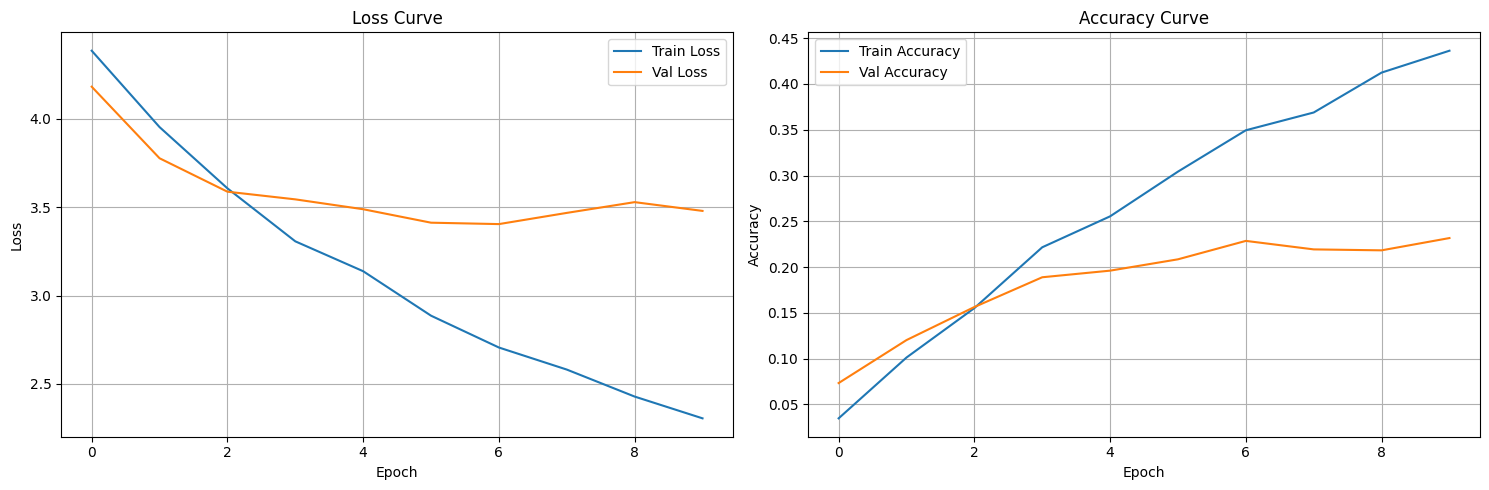

In [ ]:
plot_training_curves(train_losses, val_losses ,train_accuracies, val_accuracies)

### –¢–µ–ø–µ—Ä—å –ø–æ—Å–º–æ—Ç—Ä–∏–º –Ω–∞ –º–µ—Ç—Ä–∏–∫—É —Å –Ω–∞–≤–æ—Ä–æ—á–µ–Ω–Ω—ã–º–∏ –∞—É–≥–º–µ–Ω—Ç–∞—Ü–∏—è–º–∏

In [ ]:
train_dataset = ImageFolderDataset(root_dir="./data/train", split="train", transform=train_transform_navorochenny, rare_class_transform=rare_class_transform )
val_dataset = ImageFolderDataset(root_dir="./data/train", split="val", transform=val_transform)
test_dataset = ImageFolderDataset(root_dir="./data/test", split="test", transform=val_transform)
train_loader = DataLoader(train_dataset, batch_size=64, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

—Ç—É—Ç —É–∂–µ –ø—Ä–æ–≤–µ—Ä—é –Ω–∞ 7 —ç–ø–æ—Ö–∞—Ö, –≤ —Ü–µ–ª–æ–º, –¥–≤–∏–∂–µ–Ω–∏–µ —Å–∫–æ—Ä–∞ –±—É–¥–µ—Ç –ø–æ–Ω—è—Ç–Ω–æ:

In [ ]:
device = torch.device("mps" if torch.mps.is_available() else "cuda")
model_base = SimpleCnn(num_classes=100)
model_base = model_base.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model_base.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [ ]:
model, train_losses, train_accuracies, val_losses, val_accuracies = train_model(
    model=model_base,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    num_epochs=7,
    patience=5,
    save_path='best_model_navorot.pth')

Epoch 1/7 | Train Loss: 4.3737 | Train Acc: 0.0367
Epoch 1/7 | Val Loss: 4.1814 | Val Acc: 0.0604
–ú–µ—Ç—Ä–∏–∫–∞ –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏ —É–ª—É—á—à–∏–ª–∞—Å—å —Å 0.0000 –¥–æ 0.0604. –°–æ—Ö—Ä–∞–Ω–µ–Ω–∏–µ...
------------------------------------------------------------
Epoch 2/7 | Train Loss: 4.0570 | Train Acc: 0.0777
Epoch 2/7 | Val Loss: 3.9460 | Val Acc: 0.0960
–ú–µ—Ç—Ä–∏–∫–∞ –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏ —É–ª—É—á—à–∏–ª–∞—Å—å —Å 0.0604 –¥–æ 0.0960. –°–æ—Ö—Ä–∞–Ω–µ–Ω–∏–µ...
------------------------------------------------------------
Epoch 3/7 | Train Loss: 3.8734 | Train Acc: 0.1146
Epoch 3/7 | Val Loss: 3.7417 | Val Acc: 0.1254
–ú–µ—Ç—Ä–∏–∫–∞ –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏ —É–ª—É—á—à–∏–ª–∞—Å—å —Å 0.0960 –¥–æ 0.1254. –°–æ—Ö—Ä–∞–Ω–µ–Ω–∏–µ...
------------------------------------------------------------
Epoch 4/7 | Train Loss: 3.6699 | Train Acc: 0.1359
Epoch 4/7 | Val Loss: 3.7939 | Val Acc: 0.1238
–ú–µ—Ç—Ä–∏–∫–∞ –Ω–µ —É–ª—É—á—à–∞–µ—Ç—Å—è –Ω–∞ –ø—Ä–æ—Ç—è–∂–µ–Ω–∏–∏ 1 —ç–ø–æ—Ö. –ú–∞–∫—Å–∏–º—É–º –Ω–∞ –¥–

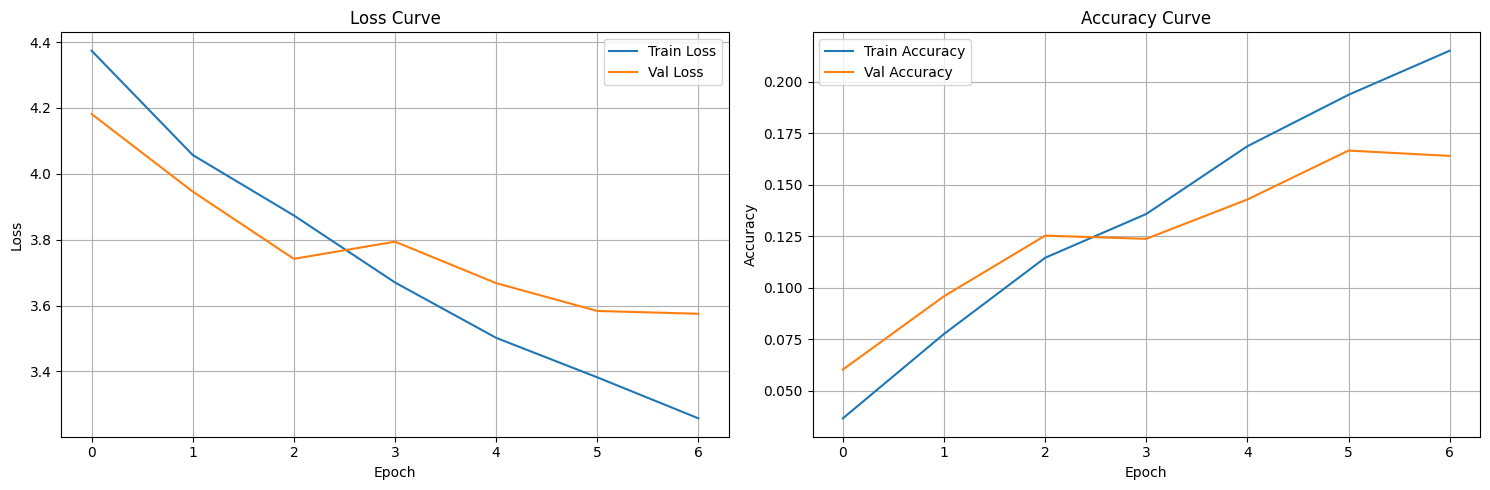

In [ ]:
plot_training_curves(train_losses, val_losses ,train_accuracies, val_accuracies)

–º–æ–∂–Ω–æ –∑–∞–º–µ—Ç–∏—Ç—å, —á—Ç–æ –¥–µ–ª–æ –ø–æ—à–ª–æ —Ö—É–∂–µ, —á–µ–º –±—ã–ª–æ –¥–æ —ç—Ç–æ–≥–æ, –æ—Å—Ç–∞–≤–∏–º –æ–±—ã—á–Ω—ã–µ –∞–≥—É–º–µ–Ω—Ç–∞—Ü–∏–∏

### –Ω–æ —á—Ç–æ, –µ—Å–ª–∏ –ø—Ä–∏–º–µ–Ω—è—Ç—å –∞–≥—É–º–µ–Ω—Ç–∞—Ü–∏—é –Ω–∞ —Ç–µ—Å—Ç–µ? üòß

In [ ]:
train_dataset = ImageFolderDataset(root_dir="./data/train", split="train", transform=train_transform, rare_class_transform=rare_class_transform )
val_dataset = ImageFolderDataset(root_dir="./data/train", split="val", transform=train_transform)
test_dataset = ImageFolderDataset(root_dir="./data/test", split="test", transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=64, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
device = torch.device("mps" if torch.mps.is_available() else "cuda")
model_base = SimpleCnn(num_classes=100)
model_base = model_base.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model_base.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [ ]:
model, train_losses, train_accuracies, val_losses, val_accuracies = train_model(
    model=model_base,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    num_epochs=7,
    patience=5,
    save_path='best_model_ofiget.pth')

Epoch 1/7 | Train Loss: 4.3231 | Train Acc: 0.0399
Epoch 1/7 | Val Loss: 4.1646 | Val Acc: 0.0619
–ú–µ—Ç—Ä–∏–∫–∞ –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏ —É–ª—É—á—à–∏–ª–∞—Å—å —Å 0.0000 –¥–æ 0.0619. –°–æ—Ö—Ä–∞–Ω–µ–Ω–∏–µ...
------------------------------------------------------------
Epoch 2/7 | Train Loss: 3.9773 | Train Acc: 0.0894
Epoch 2/7 | Val Loss: 3.9179 | Val Acc: 0.1022
–ú–µ—Ç—Ä–∏–∫–∞ –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏ —É–ª—É—á—à–∏–ª–∞—Å—å —Å 0.0619 –¥–æ 0.1022. –°–æ—Ö—Ä–∞–Ω–µ–Ω–∏–µ...
------------------------------------------------------------
Epoch 3/7 | Train Loss: 3.6493 | Train Acc: 0.1553
Epoch 3/7 | Val Loss: 3.7343 | Val Acc: 0.1419
–ú–µ—Ç—Ä–∏–∫–∞ –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏ —É–ª—É—á—à–∏–ª–∞—Å—å —Å 0.1022 –¥–æ 0.1419. –°–æ—Ö—Ä–∞–Ω–µ–Ω–∏–µ...
------------------------------------------------------------
Epoch 4/7 | Train Loss: 3.3352 | Train Acc: 0.2180
Epoch 4/7 | Val Loss: 3.5883 | Val Acc: 0.1739
–ú–µ—Ç—Ä–∏–∫–∞ –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏ —É–ª—É—á—à–∏–ª–∞—Å—å —Å 0.1419 –¥–æ 0.1739. –°–æ—Ö—Ä–∞–Ω–µ–Ω–∏–µ.

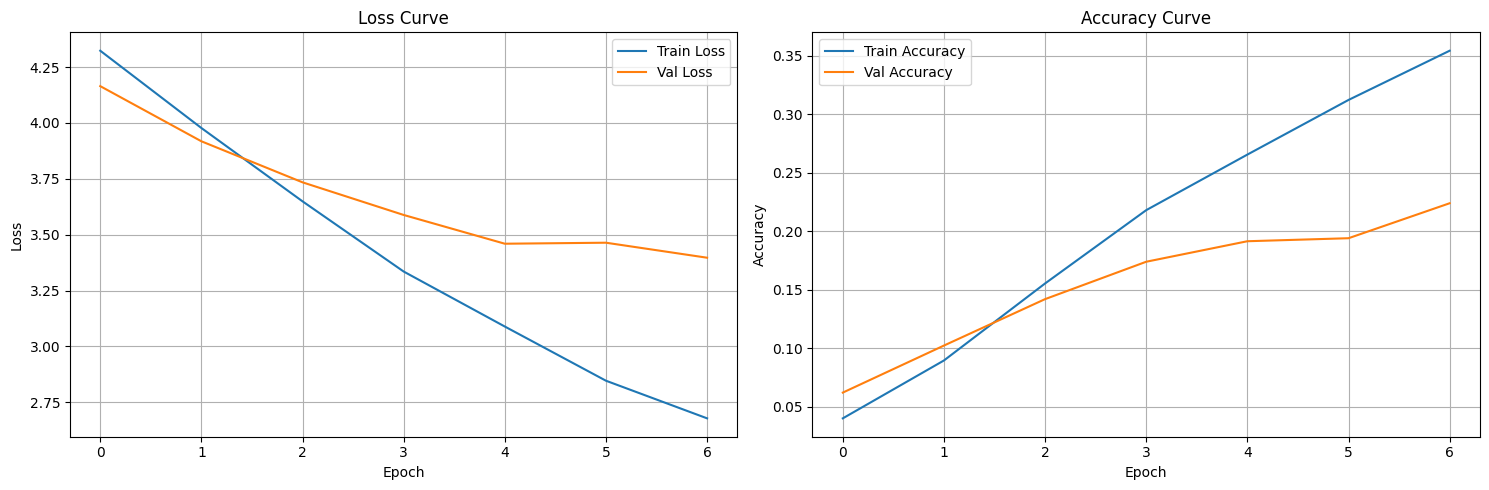

In [ ]:
plot_training_curves(train_losses, val_losses ,train_accuracies, val_accuracies)

–∏ –≤—Å–µ —Ä–∞–≤–Ω–æ —Ö—É–∂–µ, —á–µ–º –±–∞–∑–æ–≤—ã–µ –∞—É–≥–º–µ–Ω—Ç–∞—Ü–∏–∏. –æ—Å—Ç–∞–≤–∏–º –∏—Ö

------

## Resnet50

–≤–æ–∑—å–º–µ–º –ø—Ä–µ–¥–æ–±—É—á–µ–Ω–Ω—É—é –º–æ–¥–µ–ª—å (–¥–∞–ª–µ–µ –±–µ—Ä—É—Ç—Å—è —Ç–∞–∫–∂–µ –ø—Ä–µ–¥–æ–±—É—á–µ–Ω–Ω—ã–µ –º–æ–¥–µ–ª–∏)

In [ ]:
model_3 = models.resnet50(pretrained=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 97.8M/97.8M [00:00<00:00, 133MB/s]


In [ ]:
for param in model_3.parameters():
    param.requires_grad = False

In [ ]:
num_ftrs = model_3.fc.in_features
model_3.fc = nn.Linear(num_ftrs, 100)

In [ ]:
device = torch.device("mps" if torch.mps.is_available() else "cuda")
model_3 = model_3.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model_3.parameters(), lr=0.001)

In [ ]:
train_dataset = ImageFolderDataset(root_dir="./data/train",split="train",transform=train_transform,rare_class_transform=rare_class_transform,)
val_dataset = ImageFolderDataset(root_dir="./data/train", split="val", transform=val_transform)
test_dataset = ImageFolderDataset(root_dir="./data/test", split="test", transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=64, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
model_3, train_losses_3, train_accuracies_3, val_losses_3, val_accuracies_3 = train_model(model_3,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    num_epochs=10,
    patience=5,
    save_path="best_model_resnet50.pth")

Epoch 1/10 | Train Loss: 3.8971 | Train Acc: 0.1544
Epoch 1/10 | Val Loss: 2.7422 | Val Acc: 0.3911
–ú–µ—Ç—Ä–∏–∫–∞ –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏ —É–ª—É—á—à–∏–ª–∞—Å—å —Å 0.0000 –¥–æ 0.3911. –°–æ—Ö—Ä–∞–Ω–µ–Ω–∏–µ...
------------------------------------------------------------
Epoch 2/10 | Train Loss: 2.8717 | Train Acc: 0.3242
Epoch 2/10 | Val Loss: 2.2142 | Val Acc: 0.4530
–ú–µ—Ç—Ä–∏–∫–∞ –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏ —É–ª—É—á—à–∏–ª–∞—Å—å —Å 0.3911 –¥–æ 0.4530. –°–æ—Ö—Ä–∞–Ω–µ–Ω–∏–µ...
------------------------------------------------------------
Epoch 3/10 | Train Loss: 2.5045 | Train Acc: 0.3896
Epoch 3/10 | Val Loss: 1.9473 | Val Acc: 0.5093
–ú–µ—Ç—Ä–∏–∫–∞ –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏ —É–ª—É—á—à–∏–ª–∞—Å—å —Å 0.4530 –¥–æ 0.5093. –°–æ—Ö—Ä–∞–Ω–µ–Ω–∏–µ...
------------------------------------------------------------
Epoch 4/10 | Train Loss: 2.3528 | Train Acc: 0.4134
Epoch 4/10 | Val Loss: 1.8925 | Val Acc: 0.5119
–ú–µ—Ç—Ä–∏–∫–∞ –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏ —É–ª—É—á—à–∏–ª–∞—Å—å —Å 0.5093 –¥–æ 0.5119. –°–æ—Ö—Ä–∞–Ω–

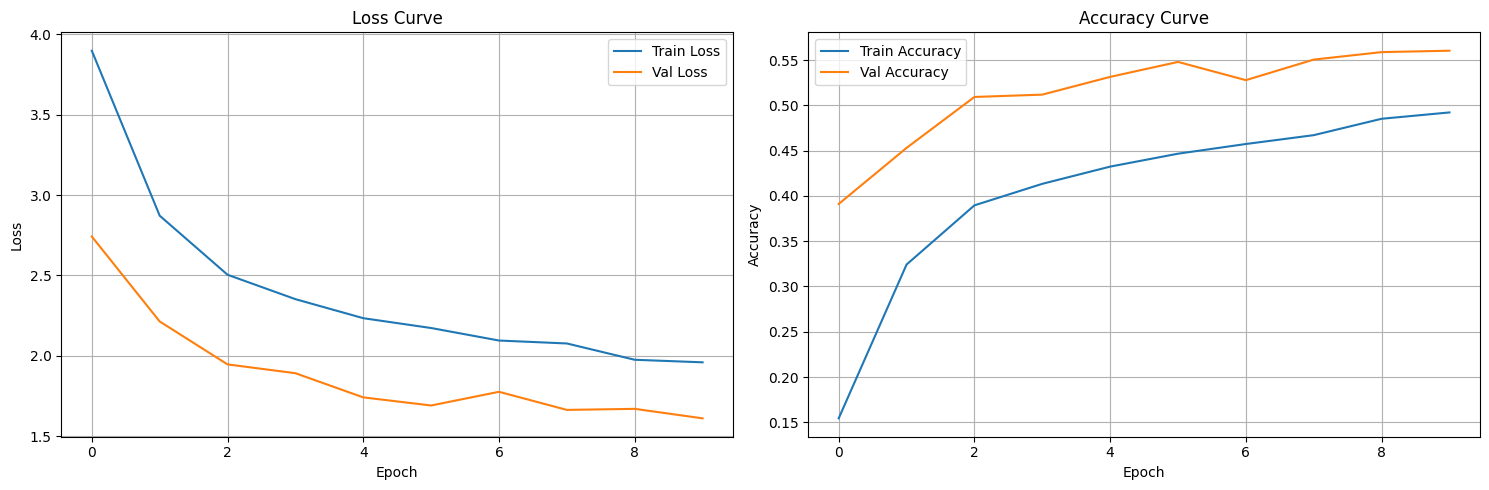

In [ ]:
plot_training_curves(train_losses_3,  val_losses_3,train_accuracies_3, val_accuracies_3)

### –ø–æ—Ñ–∞–π–Ω—Ç—é–Ω–∏–º

In [ ]:
for param in model_3.parameters():
    param.requires_grad = True

optimizer_ft = optim.AdamW(model_3.parameters(), lr=0.0001)

In [ ]:
model_3, train_losses_3, train_accuracies_3, val_losses_3, val_accuracies_3 =train_model(model_3,
    train_loader,
    val_loader,
    criterion,
    optimizer_ft,
    device,
    num_epochs=20,
    patience=5,
    save_path="best_model_resnet50_fine.pth")

Epoch 1/20 | Train Loss: 1.3136 | Train Acc: 0.6348
Epoch 1/20 | Val Loss: 1.1582 | Val Acc: 0.6589
–ú–µ—Ç—Ä–∏–∫–∞ –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏ —É–ª—É—á—à–∏–ª–∞—Å—å —Å 0.0000 –¥–æ 0.6589. –°–æ—Ö—Ä–∞–Ω–µ–Ω–∏–µ...
------------------------------------------------------------
Epoch 2/20 | Train Loss: 0.8289 | Train Acc: 0.7619
Epoch 2/20 | Val Loss: 0.9797 | Val Acc: 0.7116
–ú–µ—Ç—Ä–∏–∫–∞ –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏ —É–ª—É—á—à–∏–ª–∞—Å—å —Å 0.6589 –¥–æ 0.7116. –°–æ—Ö—Ä–∞–Ω–µ–Ω–∏–µ...
------------------------------------------------------------
Epoch 3/20 | Train Loss: 0.6090 | Train Acc: 0.8261
Epoch 3/20 | Val Loss: 0.9608 | Val Acc: 0.7317
–ú–µ—Ç—Ä–∏–∫–∞ –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏ —É–ª—É—á—à–∏–ª–∞—Å—å —Å 0.7116 –¥–æ 0.7317. –°–æ—Ö—Ä–∞–Ω–µ–Ω–∏–µ...
------------------------------------------------------------
Epoch 4/20 | Train Loss: 0.4748 | Train Acc: 0.8670
Epoch 4/20 | Val Loss: 1.0033 | Val Acc: 0.7136
–ú–µ—Ç—Ä–∏–∫–∞ –Ω–µ —É–ª—É—á—à–∞–µ—Ç—Å—è –Ω–∞ –ø—Ä–æ—Ç—è–∂–µ–Ω–∏–∏ 1 —ç–ø–æ—Ö. –ú–∞–∫—Å–∏–º—É–º 

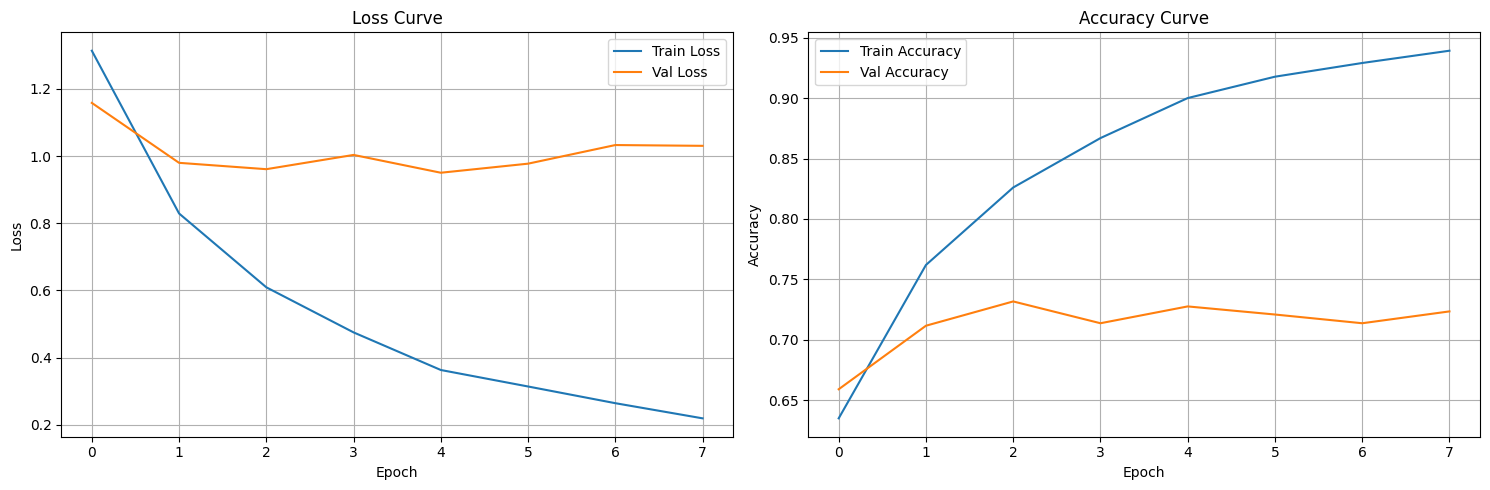

In [ ]:
plot_training_curves(train_losses_3,  val_losses_3,train_accuracies_3, val_accuracies_3)

–ø—Ä–µ–¥—Å–∫–∞–∂–µ–º

In [ ]:
my_submit = pd.read_csv("/content/sample_submission.csv")
# my_submit = pd.DataFrame({'Image_id': test_filenames, 'Expected': preds})
my_submit.head()

id  target
0   0       0
1   1       0
2   2       0
3   3       0
4   4       0

In [ ]:
my_submit['target']=predict_on_test(model_3, test_loader, device)

In [ ]:
my_submit.to_csv('resnet50_popitka.csv', index=False)

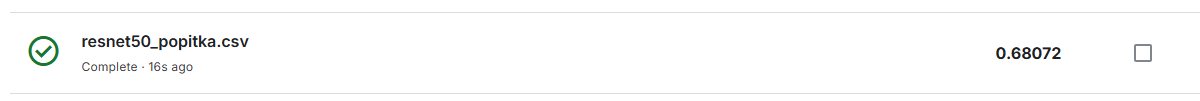

------

## **EfficientNetb3 ( –õ–£–ß–®–ê–Ø –ù–ê –ö–ê–ì–ì–õ–ï –ú–û–î–ï–õ–¨ - 0.78 )**

–∫—Ä–∞—Ç–∫–æ –∏ –ø–æ –¥–µ–ª—É: –±–µ—Ä–µ–º –ø—Ä–µ–¥–æ–±—É—á–µ–Ω–Ω—É—é –º–æ–¥–µ–ª—å, –∑–∞–º–æ—Ä–∞–∂–∏–≤–∞–µ–º —Å–ª–æ–∏, –æ–±—É—á–∞–µ–º, —Ä–∞–∑–º–æ—Ä–∞–∂–∏–≤–∞–µ–º —Å–ª–æ–∏, —Ñ–∞–π–Ω—Ç—é–Ω–∏–º.

–ø–æ —Å—Ç—Ä—É–∫—Ç—É—Ä–µ:


*   —Ç—Ä–∞–Ω—Å—Ñ–æ—Ä–º–µ—Ä —Å –±–∞–∑–æ–≤—ã–º–∏ –∞—É–≥–º–µ–Ω—Ç–∞—Ü–∏—è–º–∏ (–ø–æ–≤–æ—Ä–æ—Ç –≥–æ—Ä–∏–∑–æ–Ω—Ç–∞–ª—å–Ω–æ\–≤–µ—Ä—Ç–∏–∫–∞–ª—å–Ω–æ, —É—Å–∏–ª–µ–Ω–∏–µ —Ä–µ–∑–∫–æ—Å—Ç–∏, –∏ –Ω–µ–º–Ω–æ–≥–æ –ø—Ä–æ–ø–∞–≤—à–∏–µ –ø–∏–∫—Å–µ–ª–∏)
*   —É—Å–ª–æ–≤–Ω–∞—è –∞–≥—É–º–µ–Ω—Ç–∞—Ü–∏—è –¥–ª—è —Ä–µ–¥–∫–∏—Ö –∫–ª–∞—Å—Å–æ–≤ (–º–µ–Ω–µ–µ 40 —ç–∫–∑–µ–º–ø–ª—è—Ä–æ–≤)
*   –≤—Ä–æ–¥–µ –∫–∞–∫ —ç—Ç–∞ –º–æ–¥–µ–ª—å —Ö–æ—Ä–æ—à–æ —Ä–∞–±–æ—Ç–∞–µ—Ç –Ω–∞ 224—Ö224 - —É –º–µ–Ω—è –Ω–∞—Å—Ç—Ä–æ–µ–Ω –∞–ø—Å–∫–µ–π–ª –¥–æ —ç—Ç–∏—Ö —Ä–∞–∑–º–µ—Ä–æ–≤
*   —Å–Ω–∞—á–∞–ª–∞ 15 —ç–ø–æ—Ö, –ø–æ—Ç–æ–º –µ—â–µ 30 —ç–ø–æ—Ö
*   —É—Å–ª–æ–≤–∏–µ –¥–ª—è —Ä–∞–Ω–Ω–µ–π –æ—Å—Ç–∞–Ω–æ–≤–∫–∏ - —Å–Ω–∞—á–∞–ª–∞ 5 —ç–ø–æ—Ö, –ø–æ—Ç–æ–º 10
*   —Å–æ—Ö—Ä–∞–Ω–µ–Ω–∏–µ –ª—É—á—à–µ–π –º–æ–¥–µ–ª–∏





In [ ]:
model_5 = models.efficientnet_b3(weights="IMAGENET1K_V1")

Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-b3899882.pth
100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 47.2M/47.2M [00:00<00:00, 180MB/s]


In [ ]:
for param in model_5.parameters():
    param.requires_grad = False

In [ ]:
device = torch.device("mps" if torch.mps.is_available() else "cuda")

In [ ]:
num_f = model_5.classifier[1].in_features
model_5.classifier[1] = nn.Linear(num_f, 100)
model_5 = model_5.to(device)

In [ ]:
model_5 = model_5.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model_5.parameters(), lr=0.001)

In [ ]:
model_5, train_losses_5, train_accuracies_5, val_losses_5, val_accuracies_5 = train_model(model_5,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    num_epochs=15,
    patience=5,
    save_path="best_model_efficientnet_b3.pth")

Epoch 1/15 | Train Loss: 4.0149 | Train Acc: 0.1993
Epoch 1/15 | Val Loss: 3.3502 | Val Acc: 0.4303
–ú–µ—Ç—Ä–∏–∫–∞ –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏ —É–ª—É—á—à–∏–ª–∞—Å—å —Å 0.0000 –¥–æ 0.4303. –°–æ—Ö—Ä–∞–Ω–µ–Ω–∏–µ...
------------------------------------------------------------
Epoch 2/15 | Train Loss: 3.1413 | Train Acc: 0.3733
Epoch 2/15 | Val Loss: 2.6703 | Val Acc: 0.4964
–ú–µ—Ç—Ä–∏–∫–∞ –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏ —É–ª—É—á—à–∏–ª–∞—Å—å —Å 0.4303 –¥–æ 0.4964. –°–æ—Ö—Ä–∞–Ω–µ–Ω–∏–µ...
------------------------------------------------------------
Epoch 3/15 | Train Loss: 2.6819 | Train Acc: 0.4222
Epoch 3/15 | Val Loss: 2.2825 | Val Acc: 0.5330
–ú–µ—Ç—Ä–∏–∫–∞ –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏ —É–ª—É—á—à–∏–ª–∞—Å—å —Å 0.4964 –¥–æ 0.5330. –°–æ—Ö—Ä–∞–Ω–µ–Ω–∏–µ...
------------------------------------------------------------
Epoch 4/15 | Train Loss: 2.4661 | Train Acc: 0.4452
Epoch 4/15 | Val Loss: 2.0661 | Val Acc: 0.5475
–ú–µ—Ç—Ä–∏–∫–∞ –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏ —É–ª—É—á—à–∏–ª–∞—Å—å —Å 0.5330 –¥–æ 0.5475. –°–æ—Ö—Ä–∞–Ω–

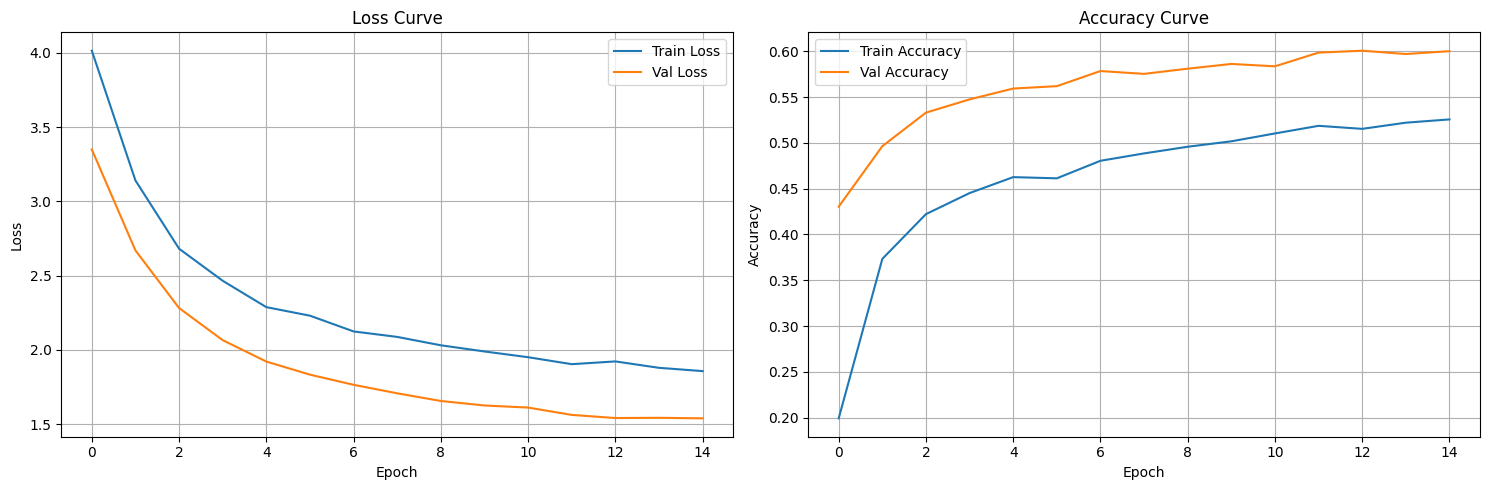

In [ ]:
plot_training_curves(train_losses_5, val_losses_5, train_accuracies_5, val_accuracies_5)

–∑–∞–ø—Ä–µ–¥–∏–∫—Ç–∏–º:

In [ ]:
my_submit = pd.read_csv("/content/sample_submission.csv")
my_submit.head()

id  target
0   0       0
1   1       0
2   2       0
3   3       0
4   4       0

In [ ]:
my_submit['target']=predict_on_test(model_5, test_loader, device)

In [ ]:
my_submit.to_csv('efficientnet_b3.csv', index=False)

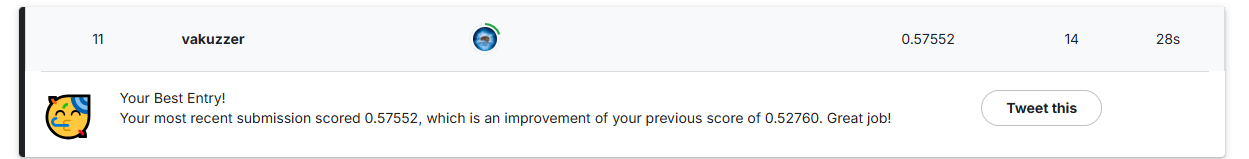

### –ø–æ—Ñ–∞–π—Ç—é–Ω–∏–º

In [ ]:
for param in model_5.parameters():
    param.requires_grad = True

optimizer_ft = optim.AdamW(model_5.parameters(), lr=0.0001)

In [ ]:
model_5, train_losses_5, train_accuracies_5, val_losses_5, val_accuracies_5 =train_model(model_5,
    train_loader,
    val_loader,
    criterion,
    optimizer_ft,
    device,
    num_epochs=30,
    patience=10,
    save_path="best_model_efficientnet_b3_fine.pth")

Epoch 1/30 | Train Loss: 1.3914 | Train Acc: 0.6198
Epoch 1/30 | Val Loss: 1.0044 | Val Acc: 0.7208
–ú–µ—Ç—Ä–∏–∫–∞ –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏ —É–ª—É—á—à–∏–ª–∞—Å—å —Å 0.0000 –¥–æ 0.7208. –°–æ—Ö—Ä–∞–Ω–µ–Ω–∏–µ...
------------------------------------------------------------
Epoch 2/30 | Train Loss: 0.9831 | Train Acc: 0.7239
Epoch 2/30 | Val Loss: 0.8766 | Val Acc: 0.7456
–ú–µ—Ç—Ä–∏–∫–∞ –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏ —É–ª—É—á—à–∏–ª–∞—Å—å —Å 0.7208 –¥–æ 0.7456. –°–æ—Ö—Ä–∞–Ω–µ–Ω–∏–µ...
------------------------------------------------------------
Epoch 3/30 | Train Loss: 0.8146 | Train Acc: 0.7598
Epoch 3/30 | Val Loss: 0.8045 | Val Acc: 0.7637
–ú–µ—Ç—Ä–∏–∫–∞ –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏ —É–ª—É—á—à–∏–ª–∞—Å—å —Å 0.7456 –¥–æ 0.7637. –°–æ—Ö—Ä–∞–Ω–µ–Ω–∏–µ...
------------------------------------------------------------
Epoch 4/30 | Train Loss: 0.6783 | Train Acc: 0.7999
Epoch 4/30 | Val Loss: 0.7630 | Val Acc: 0.7781
–ú–µ—Ç—Ä–∏–∫–∞ –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏ —É–ª—É—á—à–∏–ª–∞—Å—å —Å 0.7637 –¥–æ 0.7781. –°–æ—Ö—Ä–∞–Ω–

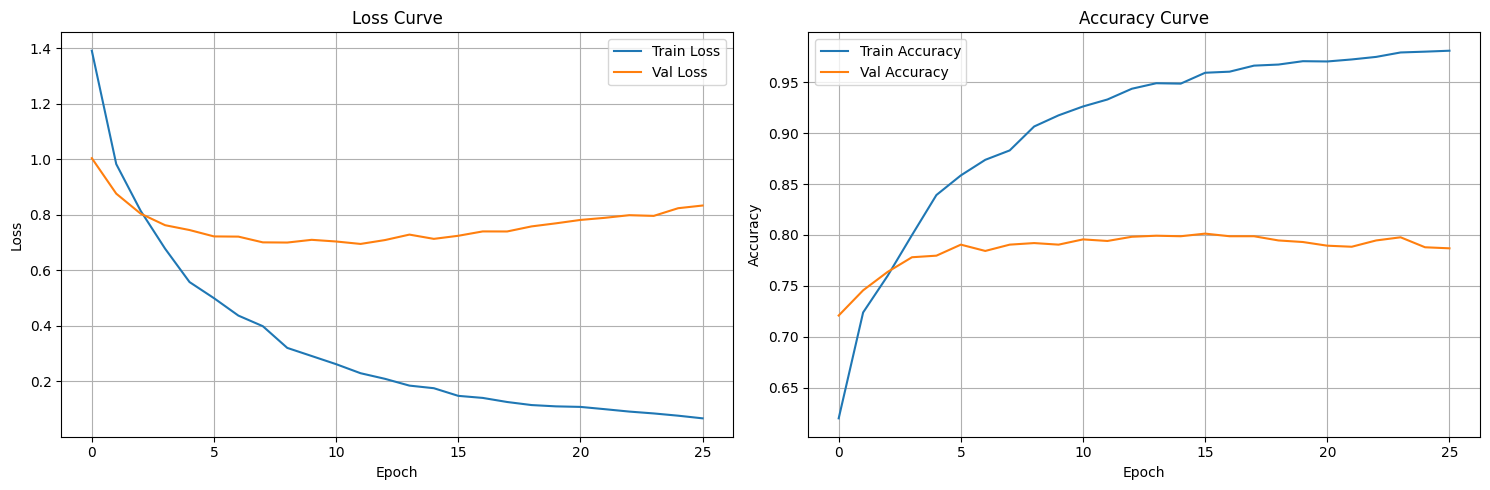

In [ ]:
plot_training_curves(train_losses_5,  val_losses_5,train_accuracies_5, val_accuracies_5)

## –û–¢–í–ï–¢ –õ–£–ß–®–ï–ô –ú–û–î–ï–õ–ò –í –ö–ê–ì–ì–õ–ï

In [ ]:
my_submit = pd.read_csv("/content/sample_submission.csv")
my_submit['target']=predict_on_test(model_5, test_loader, device)
my_submit.to_csv('efficientnet_b3_fine_2.csv', index=False)

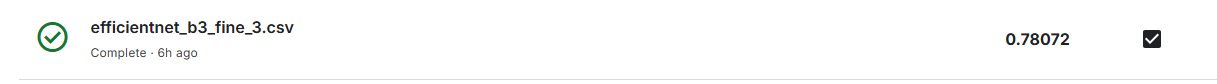

-----

## efficientnet_b5

In [ ]:
model_net = models.efficientnet_b5(weights="IMAGENET1K_V1")

In [ ]:
for param in model_net.parameters():
    param.requires_grad = False

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
device = torch.device("mps" if torch.mps.is_available() else "cuda")
num_ftrs = model_net.classifier[1].in_features
model_net.classifier[1] = nn.Linear(num_ftrs, 100)
model_net = model_net.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model_net.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [ ]:
model_net, train_losses_net, train_accuracies_net, val_losses_net, val_accuracies_net = train_model(model_net,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    num_epochs=15,
    patience=5,
    save_path="best_model_efficientnet_b5.pth")

Epoch 1/15 | Train Loss: 3.8917 | Train Acc: 0.2229
Epoch 1/15 | Val Loss: 3.2627 | Val Acc: 0.3612
–ú–µ—Ç—Ä–∏–∫–∞ –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏ —É–ª—É—á—à–∏–ª–∞—Å—å —Å 0.0000 –¥–æ 0.3612. –°–æ—Ö—Ä–∞–Ω–µ–Ω–∏–µ...
------------------------------------------------------------
Epoch 2/15 | Train Loss: 3.0081 | Train Acc: 0.3535
Epoch 2/15 | Val Loss: 2.7776 | Val Acc: 0.4236
–ú–µ—Ç—Ä–∏–∫–∞ –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏ —É–ª—É—á—à–∏–ª–∞—Å—å —Å 0.3612 –¥–æ 0.4236. –°–æ—Ö—Ä–∞–Ω–µ–Ω–∏–µ...
------------------------------------------------------------
Epoch 3/15 | Train Loss: 2.6516 | Train Acc: 0.3953
Epoch 3/15 | Val Loss: 2.5210 | Val Acc: 0.4463
–ú–µ—Ç—Ä–∏–∫–∞ –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏ —É–ª—É—á—à–∏–ª–∞—Å—å —Å 0.4236 –¥–æ 0.4463. –°–æ—Ö—Ä–∞–Ω–µ–Ω–∏–µ...
------------------------------------------------------------
Epoch 4/15 | Train Loss: 2.4483 | Train Acc: 0.4262
Epoch 4/15 | Val Loss: 2.3707 | Val Acc: 0.4623
–ú–µ—Ç—Ä–∏–∫–∞ –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏ —É–ª—É—á—à–∏–ª–∞—Å—å —Å 0.4463 –¥–æ 0.4623. –°–æ—Ö—Ä–∞–Ω–

### –ø–æ—Ñ–∞–π–Ω—Ç—é–Ω–∏–º

In [ ]:
for param in model_net.parameters():
    param.requires_grad = True

optimizer_ft = optim.AdamW(model_net.parameters(), lr=0.0001)

In [ ]:
model_net, train_losses_net, train_accuracies_net, val_losses_net, val_accuracies_net =train_model(model_net,
    train_loader,
    val_loader,
    criterion,
    optimizer_ft,
    device,
    num_epochs=20,
    patience=5,
    save_path="best_model_efficientnet_b5_fine.pth")

Epoch 1/20 | Train Loss: 1.3473 | Train Acc: 0.6342
Epoch 1/20 | Val Loss: 1.1269 | Val Acc: 0.6863
–ú–µ—Ç—Ä–∏–∫–∞ –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏ —É–ª—É—á—à–∏–ª–∞—Å—å —Å 0.0000 –¥–æ 0.6863. –°–æ—Ö—Ä–∞–Ω–µ–Ω–∏–µ...
------------------------------------------------------------
Epoch 2/20 | Train Loss: 0.8392 | Train Acc: 0.7606
Epoch 2/20 | Val Loss: 0.9841 | Val Acc: 0.7224
–ú–µ—Ç—Ä–∏–∫–∞ –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏ —É–ª—É—á—à–∏–ª–∞—Å—å —Å 0.6863 –¥–æ 0.7224. –°–æ—Ö—Ä–∞–Ω–µ–Ω–∏–µ...
------------------------------------------------------------
Epoch 3/20 | Train Loss: 0.6428 | Train Acc: 0.8184
Epoch 3/20 | Val Loss: 0.9284 | Val Acc: 0.7384
–ú–µ—Ç—Ä–∏–∫–∞ –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏ —É–ª—É—á—à–∏–ª–∞—Å—å —Å 0.7224 –¥–æ 0.7384. –°–æ—Ö—Ä–∞–Ω–µ–Ω–∏–µ...
------------------------------------------------------------
Epoch 4/20 | Train Loss: 0.5031 | Train Acc: 0.8613
Epoch 4/20 | Val Loss: 0.8859 | Val Acc: 0.7446
–ú–µ—Ç—Ä–∏–∫–∞ –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏ —É–ª—É—á—à–∏–ª–∞—Å—å —Å 0.7384 –¥–æ 0.7446. –°–æ—Ö—Ä–∞–Ω–

In [ ]:
my_submit = pd.read_csv("/content/sample_submission.csv")
my_submit['target']=predict_on_test(model_net, test_loader, device)
my_submit.to_csv('efficientnet_b5_fine.csv', index=False)

## mobilenet_v3_small

In [ ]:
model_mobilenet = models.mobilenet_v3_small(pretrained=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
for param in model_mobilenet.parameters():
    param.requires_grad = False

In [ ]:
model_mobilenet.classifier[-1] = nn.Linear(1024, 100)
model_mobilenet = model_mobilenet.to(device)

In [ ]:
device = torch.device("mps" if torch.mps.is_available() else "cuda")
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model_mobilenet.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [ ]:
model_mobilenet, train_losses_6, train_accuracies_6, val_losses_6, val_accuracies_6 = train_model(model_mobilenet,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    num_epochs=10,
    patience=5,
    save_path="best_model_mobilenet.pth")

Epoch 1/10 | Train Loss: 3.6907 | Train Acc: 0.2340
Epoch 1/10 | Val Loss: 2.6655 | Val Acc: 0.4272
–ú–µ—Ç—Ä–∏–∫–∞ –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏ —É–ª—É—á—à–∏–ª–∞—Å—å —Å 0.0000 –¥–æ 0.4272. –°–æ—Ö—Ä–∞–Ω–µ–Ω–∏–µ...
------------------------------------------------------------
Epoch 2/10 | Train Loss: 2.6794 | Train Acc: 0.4056
Epoch 2/10 | Val Loss: 2.0493 | Val Acc: 0.5036
–ú–µ—Ç—Ä–∏–∫–∞ –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏ —É–ª—É—á—à–∏–ª–∞—Å—å —Å 0.4272 –¥–æ 0.5036. –°–æ—Ö—Ä–∞–Ω–µ–Ω–∏–µ...
------------------------------------------------------------
Epoch 3/10 | Train Loss: 2.3334 | Train Acc: 0.4546
Epoch 3/10 | Val Loss: 1.8605 | Val Acc: 0.5253
–ú–µ—Ç—Ä–∏–∫–∞ –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏ —É–ª—É—á—à–∏–ª–∞—Å—å —Å 0.5036 –¥–æ 0.5253. –°–æ—Ö—Ä–∞–Ω–µ–Ω–∏–µ...
------------------------------------------------------------
Epoch 4/10 | Train Loss: 2.1355 | Train Acc: 0.4831
Epoch 4/10 | Val Loss: 1.7622 | Val Acc: 0.5439
–ú–µ—Ç—Ä–∏–∫–∞ –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏ —É–ª—É—á—à–∏–ª–∞—Å—å —Å 0.5253 –¥–æ 0.5439. –°–æ—Ö—Ä–∞–Ω–

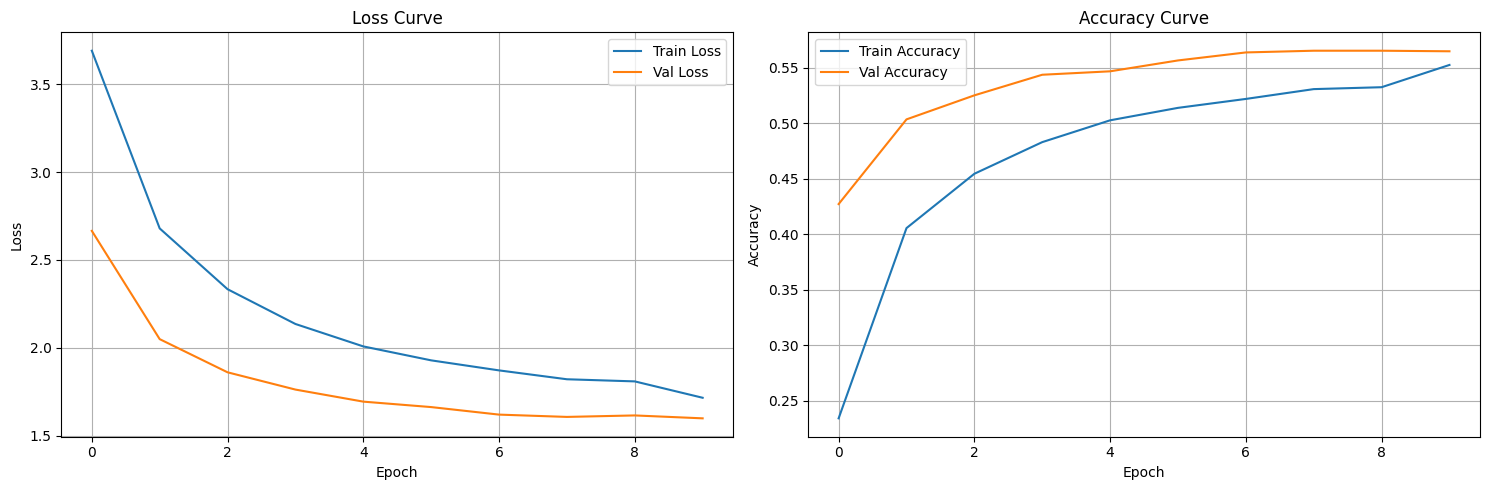

In [ ]:
plot_training_curves(train_losses_6,  val_losses_6,train_accuracies_6, val_accuracies_6)

### –ø–æ—Ñ–∞–π–Ω—Ç—é–Ω–∏–º

In [ ]:
for param in model_mobilenet.parameters():
    param.requires_grad = True

optimizer_ft = optim.AdamW(model_mobilenet.parameters(), lr=0.0001)

In [ ]:
model_mobilenet, train_losses_6, train_accuracies_6, val_losses_6, val_accuracies_6 =train_model(model_mobilenet,
    train_loader,
    val_loader,
    criterion,
    optimizer_ft,
    device,
    num_epochs=15,
    patience=5,
    save_path="best_model_mobilenet_fine.pth")

Epoch 1/15 | Train Loss: 1.3037 | Train Acc: 0.6368
Epoch 1/15 | Val Loss: 2.3407 | Val Acc: 0.4613
–ú–µ—Ç—Ä–∏–∫–∞ –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏ —É–ª—É—á—à–∏–ª–∞—Å—å —Å 0.0000 –¥–æ 0.4613. –°–æ—Ö—Ä–∞–Ω–µ–Ω–∏–µ...
------------------------------------------------------------
Epoch 2/15 | Train Loss: 0.9489 | Train Acc: 0.7240
Epoch 2/15 | Val Loss: 1.7801 | Val Acc: 0.5495
–ú–µ—Ç—Ä–∏–∫–∞ –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏ —É–ª—É—á—à–∏–ª–∞—Å—å —Å 0.4613 –¥–æ 0.5495. –°–æ—Ö—Ä–∞–Ω–µ–Ω–∏–µ...
------------------------------------------------------------
Epoch 3/15 | Train Loss: 0.7767 | Train Acc: 0.7775
Epoch 3/15 | Val Loss: 1.6577 | Val Acc: 0.5789
–ú–µ—Ç—Ä–∏–∫–∞ –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏ —É–ª—É—á—à–∏–ª–∞—Å—å —Å 0.5495 –¥–æ 0.5789. –°–æ—Ö—Ä–∞–Ω–µ–Ω–∏–µ...
------------------------------------------------------------
Epoch 4/15 | Train Loss: 0.6425 | Train Acc: 0.8133
Epoch 4/15 | Val Loss: 1.4908 | Val Acc: 0.6017
–ú–µ—Ç—Ä–∏–∫–∞ –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏ —É–ª—É—á—à–∏–ª–∞—Å—å —Å 0.5789 –¥–æ 0.6017. –°–æ—Ö—Ä–∞–Ω–

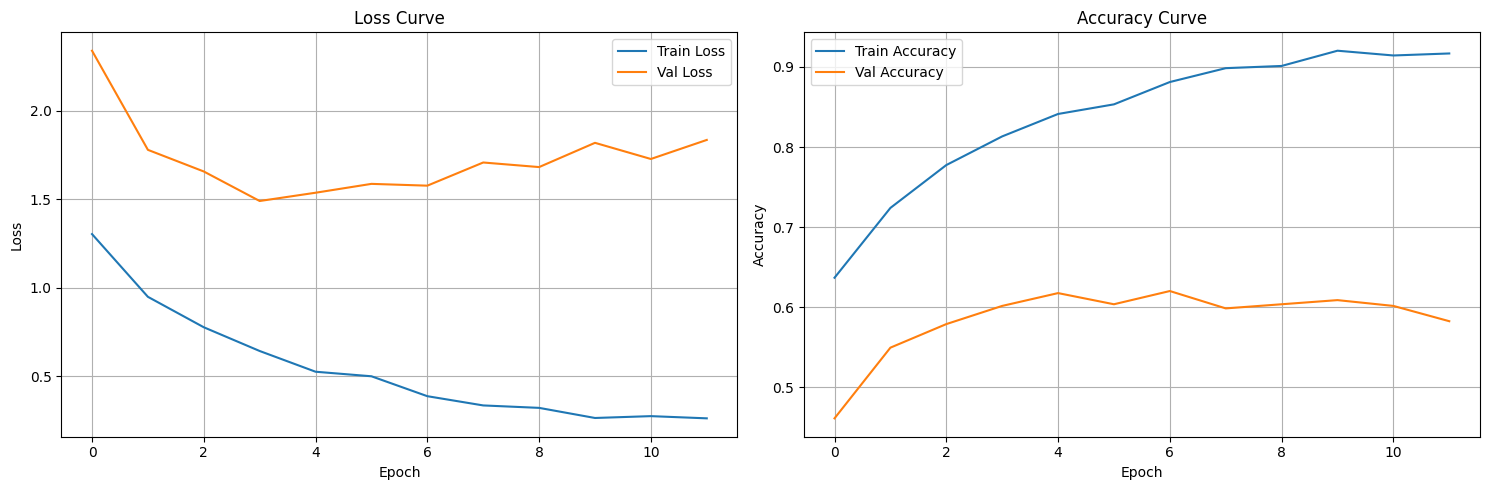

In [ ]:
plot_training_curves(train_losses_6,  val_losses_6,train_accuracies_6, val_accuracies_6)

–∑–∞–ø—Ä–µ–¥–∏–∫—Ç–∏–º

In [ ]:
my_submit = pd.read_csv("/content/sample_submission.csv")
my_submit['target']=predict_on_test(model_mobilenet, test_loader, device)
my_submit.to_csv('model_mobilenet_fine_2.csv', index=False)

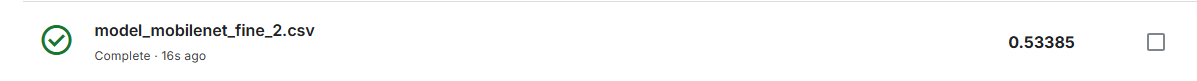

------

## densenet-169

In [ ]:
model_densenet = models.densenet169(pretrained=True)

for param in model_densenet.parameters():
    param.requires_grad = False

num_features = model_densenet.classifier.in_features
model_densenet.fc=nn.Linear(num_features, 100)

for param in model_densenet.classifier.parameters():
    param.requires_grad = True

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet169_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet169_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet169-b2777c0a.pth" to /root/.cache/torch/hub/checkpoints/densenet169-b2777c0a.pth
100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 54.7M/54.7M [00:00<00:00, 201MB/s]


In [ ]:
device = torch.device("mps" if torch.mps.is_available() else "cuda")
model_densenet = model_densenet.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model_densenet.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [ ]:
model_densenet, train_losses_densenet, train_accuracies_densenet, val_losses_densenet, val_accuracies_densenet = train_model(model_densenet,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    num_epochs=10,
    patience=5,
    save_path="best_densenet169.pth")

Epoch 1/10 | Train Loss: 5.4485 | Train Acc: 0.0449
Epoch 1/10 | Val Loss: 4.2754 | Val Acc: 0.1089
–ú–µ—Ç—Ä–∏–∫–∞ –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏ —É–ª—É—á—à–∏–ª–∞—Å—å —Å 0.0000 –¥–æ 0.1089. –°–æ—Ö—Ä–∞–Ω–µ–Ω–∏–µ...
------------------------------------------------------------
Epoch 2/10 | Train Loss: 3.6435 | Train Acc: 0.1734
Epoch 2/10 | Val Loss: 3.0437 | Val Acc: 0.2714
–ú–µ—Ç—Ä–∏–∫–∞ –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏ —É–ª—É—á—à–∏–ª–∞—Å—å —Å 0.1089 –¥–æ 0.2714. –°–æ—Ö—Ä–∞–Ω–µ–Ω–∏–µ...
------------------------------------------------------------
Epoch 3/10 | Train Loss: 2.9484 | Train Acc: 0.2866
Epoch 3/10 | Val Loss: 2.4702 | Val Acc: 0.3875
–ú–µ—Ç—Ä–∏–∫–∞ –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏ —É–ª—É—á—à–∏–ª–∞—Å—å —Å 0.2714 –¥–æ 0.3875. –°–æ—Ö—Ä–∞–Ω–µ–Ω–∏–µ...
------------------------------------------------------------
Epoch 4/10 | Train Loss: 2.5333 | Train Acc: 0.3677
Epoch 4/10 | Val Loss: 2.1317 | Val Acc: 0.4659
–ú–µ—Ç—Ä–∏–∫–∞ –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏ —É–ª—É—á—à–∏–ª–∞—Å—å —Å 0.3875 –¥–æ 0.4659. –°–æ—Ö—Ä–∞–Ω–

### –ø–æ—Ñ–∞–π—Ç—é–Ω–∏–º

In [ ]:
for param in model_densenet.parameters():
    param.requires_grad = True

optimizer_ft = optim.AdamW(model_densenet.parameters(), lr=0.0001)

In [ ]:
model_densenet, train_losses_densenet, train_accuracies_densenet, val_losses_densenet, val_accuracies_densenet =train_model(model_densenet,
    train_loader,
    val_loader,
    criterion,
    optimizer_ft,
    device,
    num_epochs=20,
    patience=5,
    save_path="model_densenet_fine.pth")

Epoch 1/20 | Train Loss: 0.8190 | Train Acc: 0.7670
Epoch 1/20 | Val Loss: 0.9655 | Val Acc: 0.7100
–ú–µ—Ç—Ä–∏–∫–∞ –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏ —É–ª—É—á—à–∏–ª–∞—Å—å —Å 0.0000 –¥–æ 0.7100. –°–æ—Ö—Ä–∞–Ω–µ–Ω–∏–µ...
------------------------------------------------------------
Epoch 2/20 | Train Loss: 0.5866 | Train Acc: 0.8332
Epoch 2/20 | Val Loss: 0.9068 | Val Acc: 0.7214
–ú–µ—Ç—Ä–∏–∫–∞ –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏ —É–ª—É—á—à–∏–ª–∞—Å—å —Å 0.7100 –¥–æ 0.7214. –°–æ—Ö—Ä–∞–Ω–µ–Ω–∏–µ...
------------------------------------------------------------
Epoch 3/20 | Train Loss: 0.4177 | Train Acc: 0.8883
Epoch 3/20 | Val Loss: 0.8956 | Val Acc: 0.7384
–ú–µ—Ç—Ä–∏–∫–∞ –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏ —É–ª—É—á—à–∏–ª–∞—Å—å —Å 0.7214 –¥–æ 0.7384. –°–æ—Ö—Ä–∞–Ω–µ–Ω–∏–µ...
------------------------------------------------------------
Epoch 4/20 | Train Loss: 0.3323 | Train Acc: 0.9120
Epoch 4/20 | Val Loss: 0.8655 | Val Acc: 0.7415
–ú–µ—Ç—Ä–∏–∫–∞ –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏ —É–ª—É—á—à–∏–ª–∞—Å—å —Å 0.7384 –¥–æ 0.7415. –°–æ—Ö—Ä–∞–Ω–

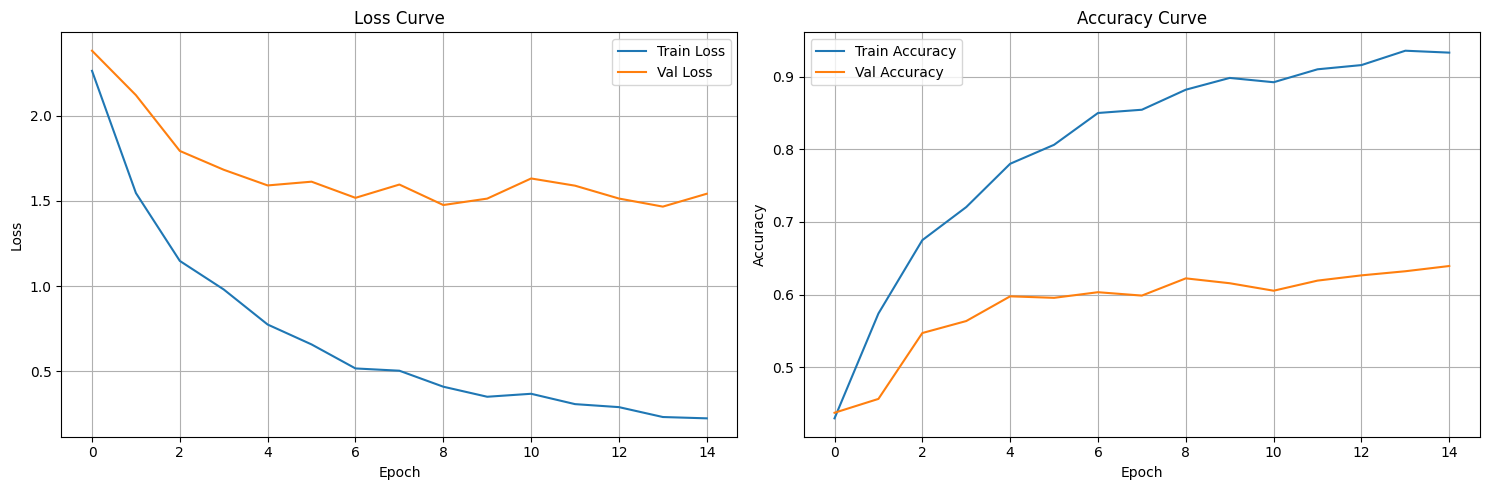

In [ ]:
plot_training_curves(train_losses_densenet,  val_losses_densenet,train_accuracies_densenet, val_accuracies_densenet)

In [ ]:
my_submit = pd.read_csv("/content/sample_submission.csv")
my_submit['target']=predict_on_test(model_densenet, test_loader, device)
my_submit.to_csv('model_densenet_fine.csv', index=False)

-----

## –Ω–µ–º–Ω–æ–≥–æ —Å–ª–æ–≤–∏–º —à–∏–∑—É - 512—Ö512 - efficientnet_v2_l

In [ ]:
train_transform_shiza = A.Compose(
    [
        A.Resize(512, 512, interpolation=cv2.INTER_CUBIC),
        A.RandomResizedCrop(size=(512, 512), scale=(0.8, 1.0), ratio=(0.9, 1.1), p=1.0),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.1),
        # A.RandomRotate90(p=0.1),
        A.PixelDropout(p=0.5),
        A.Sharpen(alpha=(0.1, 0.7)),
        A.Normalize(),
        ToTensorV2(),
    ]
)

rare_class_transform_shiza = A.Compose(
    [
        A.Resize(512, 512, interpolation=cv2.INTER_CUBIC),
        A.RandomResizedCrop(size=(512, 512), scale=(0.8, 1.0), ratio=(0.9, 1.1), p=1.0),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.1),
        A.RandomRotate90(p=0.5),
        A.PixelDropout(p=0.5),
        A.Sharpen(alpha=(0.1, 0.7)),
        A.OneOf(
            [
                A.RandomBrightnessContrast(p=0.5),
                A.HueSaturationValue(p=0.5),
                A.GaussianBlur(p=0.3),
                A.RandomGamma(p=0.3),
            ],
            p=0.5,
        ),
        A.Normalize(),
        ToTensorV2(),
    ]
)

val_transform_shiza = A.Compose([
    A.Resize(512, 512, interpolation=cv2.INTER_CUBIC),
    A.Normalize(),
    ToTensorV2()
])

In [ ]:
train_dataset = ImageFolderDataset(root_dir="./data/train", split="train", transform=train_transform_shiza, rare_class_transform=rare_class_transform_shiza )
val_dataset = ImageFolderDataset(root_dir="./data/train", split="val", transform=val_transform_shiza)
test_dataset = ImageFolderDataset(root_dir="./data/test", split="test", transform=val_transform_shiza)
train_loader = DataLoader(train_dataset, batch_size=64, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
model_7 =models.efficientnet_v2_l(weights="IMAGENET1K_V1")

Downloading: "https://download.pytorch.org/models/efficientnet_v2_l-59c71312.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_l-59c71312.pth
100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 455M/455M [00:06<00:00, 76.9MB/s]


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
for param in model_7.parameters():
    param.requires_grad = False

In [ ]:
num_ftrs = model_7.classifier[1].in_features
model_7.classifier[1] = nn.Linear(num_ftrs, 100)
model_7 = model_7.to(device)

In [ ]:
model_7 = model_7.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model_7.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [ ]:
model_7, train_losses_7, train_accuracies_7, val_losses_7, val_accuracies_7 = train_model(model_7,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    num_epochs=10,
    patience=5,
    save_path="best_model_efficientnet_v2_l.pth")

Epoch 1/10 | Train Loss: 4.2165 | Train Acc: 0.0856
Epoch 1/10 | Val Loss: 3.3653 | Val Acc: 0.2802
–ú–µ—Ç—Ä–∏–∫–∞ –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏ —É–ª—É—á—à–∏–ª–∞—Å—å —Å 0.0000 –¥–æ 0.2802. –°–æ—Ö—Ä–∞–Ω–µ–Ω–∏–µ...
------------------------------------------------------------
Epoch 2/10 | Train Loss: 3.4249 | Train Acc: 0.2241
Epoch 2/10 | Val Loss: 2.7931 | Val Acc: 0.3906
–ú–µ—Ç—Ä–∏–∫–∞ –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏ —É–ª—É—á—à–∏–ª–∞—Å—å —Å 0.2802 –¥–æ 0.3906. –°–æ—Ö—Ä–∞–Ω–µ–Ω–∏–µ...
------------------------------------------------------------
Epoch 3/10 | Train Loss: 3.0618 | Train Acc: 0.2793
Epoch 3/10 | Val Loss: 2.4474 | Val Acc: 0.4319
–ú–µ—Ç—Ä–∏–∫–∞ –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏ —É–ª—É—á—à–∏–ª–∞—Å—å —Å 0.3906 –¥–æ 0.4319. –°–æ—Ö—Ä–∞–Ω–µ–Ω–∏–µ...
------------------------------------------------------------
Epoch 4/10 | Train Loss: 2.8561 | Train Acc: 0.3127
Epoch 4/10 | Val Loss: 2.2037 | Val Acc: 0.4819
–ú–µ—Ç—Ä–∏–∫–∞ –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏ —É–ª—É—á—à–∏–ª–∞—Å—å —Å 0.4319 –¥–æ 0.4819. –°–æ—Ö—Ä–∞–Ω–

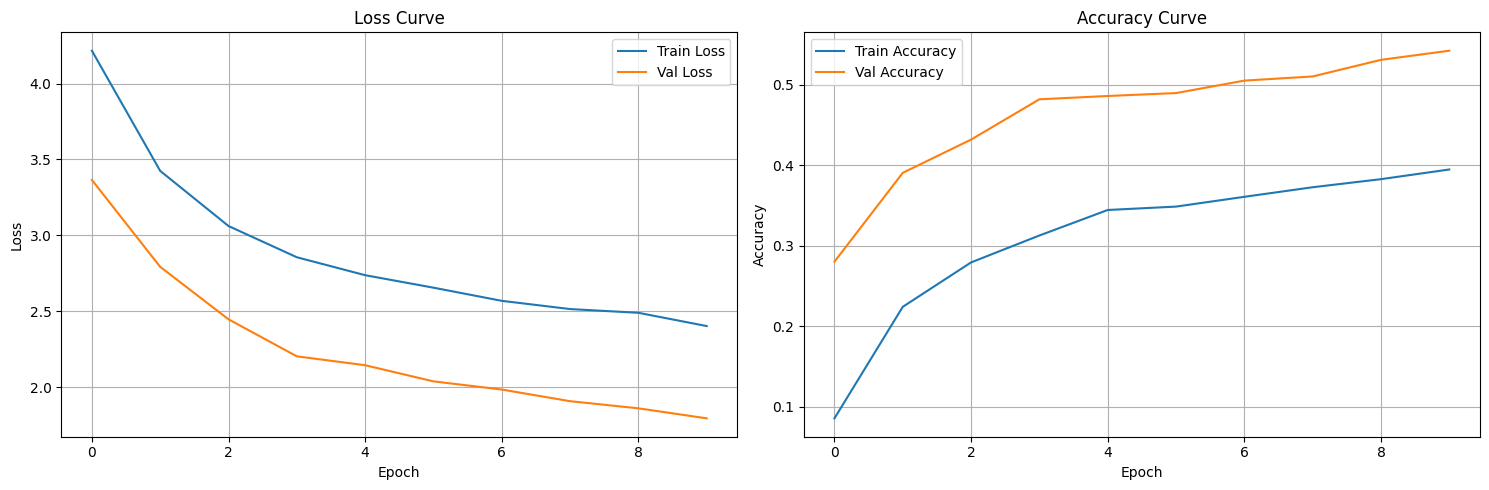

In [ ]:
plot_training_curves(train_losses_7,  val_losses_7, train_accuracies_7, val_accuracies_7)

–ø—Ä–µ–¥–∏–∫—Ç

In [ ]:
my_submit = pd.read_csv("/content/sample_submission.csv")
my_submit['target']=predict_on_test(model_7, test_loader, device)
my_submit.to_csv('model_efficientnet_v2_l.csv', index=False)

### –ø–æ—Ñ–∞–π–Ω—Ç—é–Ω–∏–º

In [ ]:
for param in model_7.parameters():
    param.requires_grad = True

optimizer_ft = optim.AdamW(model_7.parameters(), lr=0.0001)

In [ ]:
model_7, train_losses_densenet, train_accuracies_densenet, val_losses_densenet, val_accuracies_densenet =train_model(model_7,
    train_loader,
    val_loader,
    criterion,
    optimizer_ft,
    device,
    num_epochs=10,
    patience=5,
    save_path="model_efficientnet_v2_l_fine.pth")

OutOfMemoryError: CUDA out of memory. Tried to allocate 1024.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 248.12 MiB is free. Process 2408 has 14.50 GiB memory in use. Of the allocated memory 13.65 GiB is allocated by PyTorch, and 727.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

—à–∏–∑–∞ –Ω–µ —Å–ª–æ–≤–∏–ª–∞—Å—å, –≥–ø—É –≤ –∫–æ–ª–ª–∞–±–µ –∑–∞–∫–æ–Ω—á–∏–ª—Å—è (–∞ –Ω–∞—á–∏–Ω–∞–ª–æ—Å—å —Ç–∞–∫ –∫—Ä–∞—Å–∏–≤–æ....)

----------

# –ø–æ—Å—Ç—Ä–æ–∏–º cGAN

–ø–æ—Å—Ç—Ä–æ–∏–ª–∞ –≥–∞–Ω –ø–æ —Ç–∏–ø—É —Ç–æ–≥–æ, —á—Ç–æ –±—ã–ª –Ω–∞ —Å–µ–º–∏–Ω–∞—Ä–µ:

In [ ]:
latent_dim = 100
num_classes = 100
image_size = 224
channels = 3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# –Ω–∞—à –º–æ—à–µ–Ω–Ω–∏–∫
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim
        self.num_classes = num_classes
        self.init_size = image_size // 16
        self.l1 = nn.Linear(latent_dim + num_classes, 512 * self.init_size**2)

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(512),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(512, 256, 3, stride=1, padding=1),
            nn.BatchNorm2d(256, 0.8),
            nn.ReLU(),

            nn.Upsample(scale_factor=2),
            nn.Conv2d(256, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.ReLU(),

            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.ReLU(),

            nn.Upsample(scale_factor=2),
            nn.Conv2d(64, channels, 3, stride=1, padding=1),
            nn.Tanh()  # –æ—Ç -1 –¥–æ 1!
        )

    def forward(self, noise, labels):
        # –∑–∞–≤–∞–Ω—Ö–æ—Ç–∏–º –º–µ—Ç–∫–∏ –∫–ª–∞—Å—Å–æ–≤
        label_onehot = F.one_hot(labels, num_classes=self.num_classes).float()
        gen_input = torch.cat((noise, label_onehot), dim=-1)
        out = self.l1(gen_input)
        out = out.view(out.shape[0], 512, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img

# –Ω–∞—à –±–æ—Ä–µ—Ü –∑–∞ —Å–ø—Ä–∞–≤–µ–¥–ª–∏–≤–æ—Å—Ç—å
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.num_classes = num_classes

        def discriminator_block(in_filters, out_filters, bn=True):
            block = [nn.Conv2d(in_filters, out_filters, 4, 2, 1)]
            if bn:
                block.append(nn.BatchNorm2d(out_filters, 0.8))
            block.extend([nn.ReLU(), nn.Dropout2d(0.25)])
            return block
        self.conv_blocks = nn.Sequential(
            *discriminator_block(channels + num_classes, 64, bn=False),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512),
        )
        self.adv_layer = nn.Sequential(
            nn.Linear(512 * 14 * 14, 1),
            nn.Sigmoid()
        )

    def forward(self, img, labels):
        label_onehot = F.one_hot(labels, num_classes=self.num_classes).float()
        label_map = label_onehot.view(labels.size(0), self.num_classes, 1, 1).expand(-1, -1, img.size(2), img.size(3))
        conditioned_img = torch.cat((img, label_map), dim=1)
        out = self.conv_blocks(conditioned_img)
        out = out.view(out.shape[0], -1)
        validity = self.adv_layer(out)
        return validity

# –ø–æ–ø—Ä–æ—É–±–µ–º –∑–∞–ø—É—Å—Ç–∏—Ç—å –º–æ–¥–µ–ª—å–∫–∏
G = Generator().to(device)
D = Discriminator().to(device)

criterion = nn.BCELoss()
optimizer_G = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))


def train(num_epochs):
    for epoch in range(num_epochs):
        for i, (real_imgs, labels) in enumerate(train_loader):
            real_imgs = real_imgs.to(device)
            labels = labels.to(device)
            batch_size = real_imgs.size(0)
            # –æ–±–æ–∑–Ω–∞—á–∞–µ–º —Ä–µ–∞–ª—å–Ω—ã–µ –∏ —Ñ–µ–π–∫–æ–≤—ã–µ —Ñ–æ—Ç–∫–∏
            valid = torch.ones(batch_size, 1, device=device)
            fake = torch.zeros(batch_size, 1, device=device)
            # –æ–±—É—á–∏–º –Ω–∞—à –¥–∏—Å–∫—Ä–∏–º–∏–Ω–∞—Ç–æ—Ä
            optimizer_D.zero_grad()
            output_real = D(real_imgs, labels)
            loss_real = criterion(output_real, valid)

            # –ì–µ–Ω–µ—Ä–∞—Ü–∏—è —Ñ–µ–π–∫–æ–≤—ã—Ö –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–π
            noise = torch.randn(batch_size, latent_dim, device=device)
            fake_imgs = G(noise, labels)

            # –ü–æ—Ç–µ—Ä–∏ –Ω–∞ —Ñ–µ–π–∫–æ–≤—ã—Ö –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏—è—Ö
            output_fake = D(fake_imgs.detach(), labels)
            loss_fake = criterion(output_fake, fake)

            loss_D = (loss_real + loss_fake) / 2
            loss_D.backward()
            optimizer_D.step()

            # –æ–±—É—á–∏–º –Ω–∞—à –≥–µ–Ω–µ—Ä–∞—Ç–æ—Ä
            optimizer_G.zero_grad()
            output = D(fake_imgs, labels)
            loss_G = criterion(output, valid)
            loss_G.backward()
            optimizer_G.step()
            # –∏ –ø—Ä–æ—Å—Ç–æ —á–µ–∫–Ω–µ–º —Ä–µ–∑—É–ª—å—Ç–∞—Ç—ã
            if i % 50 == 0:
                print(f"[Epoch {epoch}/{num_epochs}] [Batch {i}/{len(train_loader)}] "
                      f"[D loss: {loss_D.item():.4f}] [G loss: {loss_G.item():.4f}]")


train(num_epochs=10)



[Epoch 0/10] [Batch 0/119] [D loss: 0.6914] [G loss: 0.6699]
[Epoch 0/10] [Batch 50/119] [D loss: 0.7604] [G loss: 1.2551]
[Epoch 0/10] [Batch 100/119] [D loss: 0.0809] [G loss: 2.8665]
[Epoch 1/10] [Batch 0/119] [D loss: 0.1597] [G loss: 3.0188]
[Epoch 1/10] [Batch 50/119] [D loss: 0.0258] [G loss: 4.3038]
[Epoch 1/10] [Batch 100/119] [D loss: 0.0882] [G loss: 4.1798]
[Epoch 2/10] [Batch 0/119] [D loss: 0.0047] [G loss: 4.5453]
[Epoch 2/10] [Batch 50/119] [D loss: 0.0016] [G loss: 6.1205]
[Epoch 2/10] [Batch 100/119] [D loss: 0.0020] [G loss: 6.2472]
[Epoch 3/10] [Batch 0/119] [D loss: 0.0020] [G loss: 7.6072]
[Epoch 3/10] [Batch 50/119] [D loss: 0.0004] [G loss: 7.4772]
[Epoch 3/10] [Batch 100/119] [D loss: 0.0018] [G loss: 7.8038]
[Epoch 4/10] [Batch 0/119] [D loss: 0.0046] [G loss: 4.6488]
[Epoch 4/10] [Batch 50/119] [D loss: 0.0485] [G loss: 3.6332]
[Epoch 4/10] [Batch 100/119] [D loss: 0.0089] [G loss: 4.8689]
[Epoch 5/10] [Batch 0/119] [D loss: 0.0050] [G loss: 4.1975]
[Epoch 5/

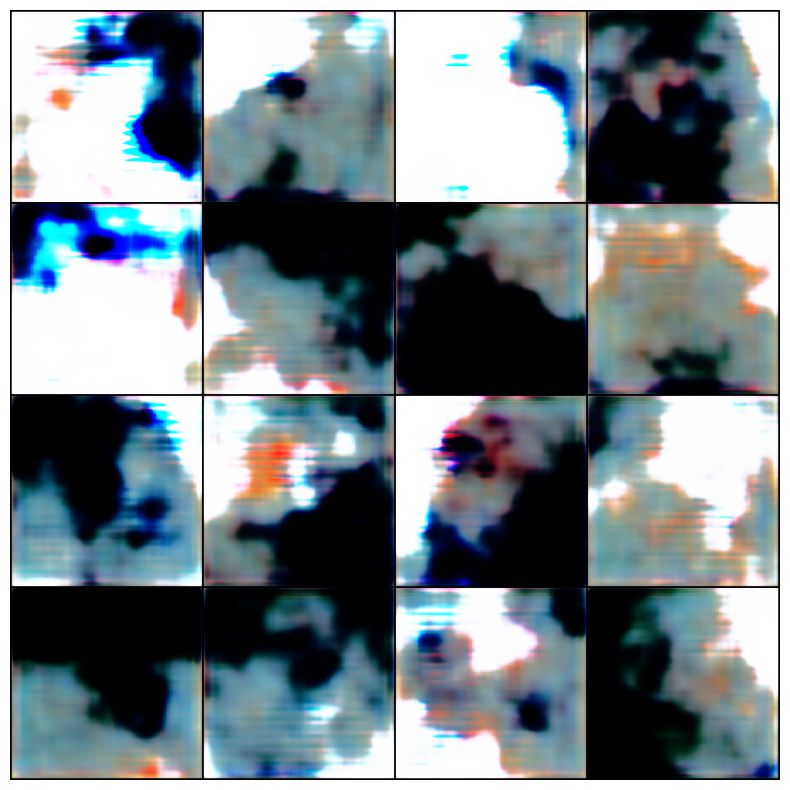

In [ ]:
G.eval()
# –ø–æ—Å–º–æ—Ç—Ä–∏–º, –∫–∞–∫ –Ω–∞—à –º–µ–≥–∞–º–æ–∑–≥ –≥–µ–Ω–µ—Ä–∏—Ç –∫–∞—Ä—Ç–∏–Ω–∫–∏ (–≤—ã–¥–∞–¥–∏–º —Å–ª—É—á–∞–π–Ω–æ 16 –∫–∞—Ä—Ç–∏–Ω–æ–∫ —Å —Ä–∞–Ω–¥–æ–º–Ω—ã–º–∏ –º–µ—Ç–∫–∞–º–∏)
num_images = 16
noise = torch.randn(num_images, latent_dim, device=device)
labels = torch.randint(0, num_classes, (num_images,), device=device)
with torch.no_grad():
    generated_images = G(noise, labels).cpu()
    # –Ω–µ –∑–∞–±—ã–≤–∞–µ–º –Ω–æ—Ä–º–∞–ª–∏–∑–∞—Ü–∏—é
    generated_images = generated_images * 0.5 + 0.5
    grid = vutils.make_grid(generated_images, nrow=4, padding=2, normalize=False)
    plt.figure(figsize=(10, 10))
    plt.imshow(grid.permute(1, 2, 0))
    plt.axis('off')
    plt.show()

–æ—Ç–ª–∏—á–Ω–æ! –º—ã –Ω–∞–≥–µ–Ω–µ—Ä–∏–ª–∏ –∫–∞–∫—É—é-—Ç–æ –∂—É—Ç—å. —Å–∫–æ—Ä–µ–µ –≤—Å–µ–≥–æ, —ç—Ç–æ –ø—Ä–æ–∏–∑–æ—à–ª–æ –∏–∑-–∑–∞ –≤—Å–µ–≥–æ 10 —ç–ø–æ—Ö –æ–±—É—á–µ–Ω–∏—è)

In [ ]:
class GeneratedDataset(Dataset):
    def __init__(self, generator, num_samples, latent_dim, num_classes, device):
        self.generator = generator
        self.num_samples = num_samples
        self.latent_dim = latent_dim
        self.num_classes = num_classes
        self.device = device
        with torch.no_grad():
            noise = torch.randn(num_samples, latent_dim, device=device)
            labels = torch.randint(0, num_classes, (num_samples,), device=device)
            self.images = generator(noise, labels).cpu()
            self.labels = labels.cpu()

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]
# –≥–µ–Ω–µ—Ä–∏–º 100 —Ñ–æ—Ç–æ–∫ –∏ —Å–æ–∑–¥–∞–µ–º —Å–º–µ—à–∞–Ω–Ω—ã–π –¥–∞—Ç–∞—Å–µ—Ç

num_generated = 100
generated_dataset = GeneratedDataset(G, num_generated, latent_dim, num_classes, device)
combo_dataset = ConcatDataset([train_dataset, generated_dataset])


—Ç—É—Ç —É –º–µ–Ω—è –∑–∞–∫–æ–Ω—á–∏–ª–∞—Å—å –ø–∞–º—è—Ç—å (–ø—Ä–∏ –ø–æ–ø—ã—Ç–∫–µ –¥–æ–±–∞–≤–∏—Ç—å 1000 —Å–≥–µ–Ω–µ—Ä–µ–Ω–Ω—ã—Ö —Ñ–æ—Ç–æ–∫) ) –Ω–æ –Ω–µ —Å–¥–∞–µ–º—Å—è, –∏ –¥–æ–±–∞–≤–ª—è–µ–º —Ö–æ—Ç—è –±—ã 100 —Å–≥–µ–Ω–µ—Ä–∏—Ä–æ–≤–∞–Ω–Ω—ã—Ö —Ñ–æ—Ç–æ–∫



In [ ]:
def collate_function(batch):
    images = torch.stack([item[0] for item in batch])
    labels = []
    for item in batch:
      # –µ—Å–ª–∏ –º–µ—Ç–∫–∞ = —Ç–µ–Ω–∑–æ—Ä, —Ç–æ –æ—Å—Ç–∞–≤–ª—è–µ–º, –µ—Å–ª–∏ –º–µ—Ç–∫–∞ = —á–∏—Å–ª–æ, —Ç–æ –ø—Ä–µ–≤—Ä–∞—â–∞–µ–º –µ–µ –≤ —Ç–µ–Ω–∑–æ—Ä
        if isinstance(item[1], torch.Tensor):
            labels.append(item[1])
        else:
          # –Ω–µ –∑–∞–±—ã–≤–∞–µ–º –∫–æ–≤–∞—Ä–Ω—ã–π .long
            labels.append(torch.tensor(item[1], dtype=torch.long))
    return images, torch.stack(labels)



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


–ø–æ–¥–≥—Ä—É–∑–∏–º –Ω–∞—à –¥–∞—Ç–∞—Å–µ—Ç

In [ ]:
combo_loader = DataLoader(
    combo_dataset,
    batch_size=16,
    shuffle=True,
    collate_fn=collate_function,
    num_workers=4
)

### –ø—Ä–æ–±—É–µ–º –æ—Ü–µ–Ω–∏—Ç—å –≤–ª–∏—è–Ω–∏–µ

In [ ]:
device = torch.device("mps" if torch.mps.is_available() else "cuda")
model_base = SimpleCnn(num_classes=100)
model_base = model_base.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model_base.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [ ]:
model, train_losses, train_accuracies, val_losses, val_accuracies = train_model(
    model=model_base,
    train_loader=combo_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    num_epochs=7,
    patience=5,
    save_path='best_model_gan.pth')

Epoch 1/7 | Train Loss: 4.2762 | Train Acc: 0.0610
Epoch 1/7 | Val Loss: 4.0167 | Val Acc: 0.0888
–ú–µ—Ç—Ä–∏–∫–∞ –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏ —É–ª—É—á—à–∏–ª–∞—Å—å —Å 0.0000 –¥–æ 0.0888. –°–æ—Ö—Ä–∞–Ω–µ–Ω–∏–µ...
------------------------------------------------------------
Epoch 2/7 | Train Loss: 3.8229 | Train Acc: 0.1243
Epoch 2/7 | Val Loss: 3.7947 | Val Acc: 0.1373
–ú–µ—Ç—Ä–∏–∫–∞ –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏ —É–ª—É—á—à–∏–ª–∞—Å—å —Å 0.0888 –¥–æ 0.1373. –°–æ—Ö—Ä–∞–Ω–µ–Ω–∏–µ...
------------------------------------------------------------
Epoch 3/7 | Train Loss: 3.5294 | Train Acc: 0.1734
Epoch 3/7 | Val Loss: 3.6230 | Val Acc: 0.1667
–ú–µ—Ç—Ä–∏–∫–∞ –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏ —É–ª—É—á—à–∏–ª–∞—Å—å —Å 0.1373 –¥–æ 0.1667. –°–æ—Ö—Ä–∞–Ω–µ–Ω–∏–µ...
------------------------------------------------------------
Epoch 4/7 | Train Loss: 3.2678 | Train Acc: 0.2245
Epoch 4/7 | Val Loss: 3.4506 | Val Acc: 0.1981
–ú–µ—Ç—Ä–∏–∫–∞ –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏ —É–ª—É—á—à–∏–ª–∞—Å—å —Å 0.1667 –¥–æ 0.1981. –°–æ—Ö—Ä–∞–Ω–µ–Ω–∏–µ.

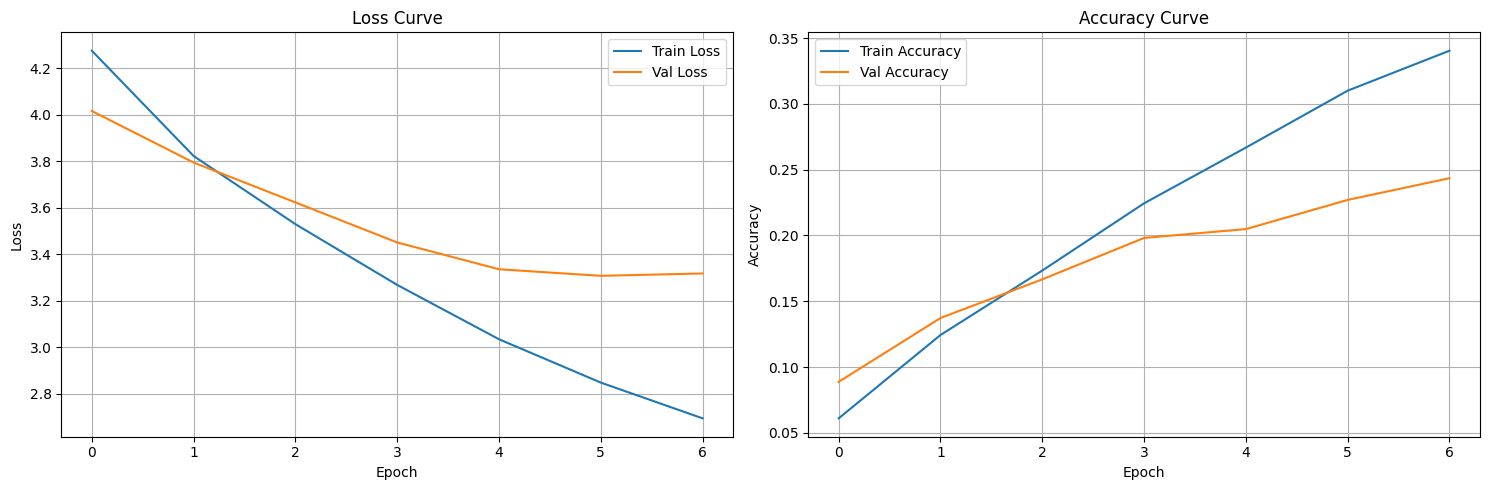

In [ ]:
plot_training_curves(train_losses, val_losses ,train_accuracies, val_accuracies)

—Ä–∞–±–æ—Ç–∞–µ—Ç —á—É—Ç—å –ª—É—á—à–µ, —á–µ–º –±–∞–∑–æ–≤–∞—è –º–æ–¥–µ–ª—å –±–µ–∑ –≥–∞–Ω–∞!